# Data Mining - Clustering Profiling Group 5

# This notebook was developed by:

- Daniel Caridade (20211588)
- Gonçalo Teles (20211684)
- Gonçalo Peres (20211625)
- João Venichand (20211664)

# Table of Content

- [1. Importing Libraries](#1-importing-libraries)
- [2. Data Integration](#2-data-integration)
    - [2.1. Data Description](#21-data-description)
- [3. Additional Features Recreation](#3-additional-features-recreation)
- [4. Data Preprocessing](#4-data-preprocessing)
    - [4.1. Solving Incoherences](#41-solving-incoherences)
    - [4.2. Feature Engineering](#42-feature-engineering)
    - [4.3. Handling Missing Values](#43-handling-missing-values)
    - [4.4. Outliers](#44-outliers)
- [5. Feature Selection](#5-feature-selection)
- [6. Clustering](#6-clustering)
    - [6.1. Customer Activity Perspective](#61-customer-activity-perspective)
    - [6.2. Cuisine Preferences Perspective](#62-cuisine-preferences-perspective)
- [7. Profiling](#7-profiling)
    - [7.1. Joining Both Perspectives](#71-joining-both-perspectives)
    - [7.2. Cluster Analysis](#72-cluster-analysis)
    - [7.3. Profiling Using Categorical Features](#73-profiling-using-categorical-features)
- [8. Cluster Visualization](#8-cluster-visualization)

# 1. Importing libraries

__`Step 1`__ Import the required libraries.

In [1]:
# EDA
import pandas as pd 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
import warnings

# Pre-processing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from scipy.stats import johnsonsu


# Clustering
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Profiling
from sklearn.metrics import pairwise_distances
import umap 


# 2. Data Integration

__`Step 2`__ Use the method **.read_csv()** to import the dataset, storing it in the data frame **data** and checking the top 5 rows with the  **.head()** method.

In [2]:
data = pd.read_csv('DM2425_ABCDEats_DATASET.csv')
data.head()

customer_id customer_region  customer_age  vendor_count  product_count  \
0  1b8f824d5e            2360          18.0             2              5   
1  5d272b9dcb            8670          17.0             2              2   
2  f6d1b2ba63            4660          38.0             1              2   
3  180c632ed8            4660           NaN             2              3   
4  4eb37a6705            4660          20.0             2              5   

   is_chain  first_order  last_order last_promo payment_method  ...  HR_14  \
0         1          0.0           1   DELIVERY           DIGI  ...      0   
1         2          0.0           1   DISCOUNT           DIGI  ...      0   
2         2          0.0           1   DISCOUNT           CASH  ...      0   
3         1          0.0           2   DELIVERY           DIGI  ...      1   
4         0          0.0           2          -           DIGI  ...      0   

   HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  
0      0      0      0      2      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0  

[5 rows x 56 columns]

__`Step 2.1`__ Create a copy of the data dataframe called **df**.

In [3]:
df = data.copy()

- We will use the dataframe **data** as a static representation of the the original dataset. This allows us to continuously monitor the percentage of data removed, ensuring it does not exceed the commonly accepted threshold of 5% (rule of thumb).
- The dataframe **df** will be the one that will suffer all the transformations through the Data Preprocessing stage.

__`Step 3`__ Setting `customer_id` as index.

In [4]:
df.set_index('customer_id', inplace=True)
df.head()

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
1b8f824d5e             2360          18.0             2              5   
5d272b9dcb             8670          17.0             2              2   
f6d1b2ba63             4660          38.0             1              2   
180c632ed8             4660           NaN             2              3   
4eb37a6705             4660          20.0             2              5   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
1b8f824d5e          1          0.0           1   DELIVERY           DIGI   
5d272b9dcb          2          0.0           1   DISCOUNT           DIGI   
f6d1b2ba63          2          0.0           1   DISCOUNT           CASH   
180c632ed8          1          0.0           2   DELIVERY           DIGI   
4eb37a6705          0          0.0           2          -           DIGI   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
1b8f824d5e           0.00  ...      0      0      0      0      2      0   
5d272b9dcb          12.82  ...      0      0      0      0      0      0   
f6d1b2ba63           9.20  ...      0      0      0      0      0      0   
180c632ed8           0.00  ...      1      0      0      0      0      0   
4eb37a6705          14.57  ...      0      0      0      0      0      0   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
1b8f824d5e       0      0      0      0  
5d272b9dcb       0      0      0      0  
f6d1b2ba63       0      0      0      0  
180c632ed8       0      0      0      0  
4eb37a6705       0      0      0      0  

[5 rows x 55 columns]

### 2.1 Data Description

`customer_id:` Unique identifier for each customer. <br>
`customer_region:` Geographic region where the customer is located. <br>
`customer_age:` Age of the customer. <br>
`vendor_count:` Number of unique vendors the customer has ordered from. <br>
`product_count:` Total number of products the customer has ordered. <br>
`is_chain:` Indicates whether the customer’s order was from a chain restaurant. <br>
`first_order:` Number of days from the start of the dataset when the customer first placed an order. <br>
`last_order:` Number of days from the start of the dataset when the customer most recently placed an order. <br>
`last_promo:` The category of the promotion or discount most recently used by the customer. <br>
`payment_method:` Method most recently used by the customer to pay for their orders. <br>
`CUI_American, CUI_Asian, CUI_Chinese, CUI_Italian, etc:` The amount in monetary units spent by the customer from the indicated type of cuisine. <br>
`DOW_0 to DOW_6:` Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday). <br>
`HR_0 to HR_23:` Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

# 3. Additional Features Recreation

__`Step 4`__ Create the additional features explored in the EDA.

In [5]:
# Create feature D_orders
df['D_orders'] = df[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']].sum(axis=1)

# Create feature H_orders
df['H_orders'] = df[['HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 
                    'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']].sum(axis=1)

# Create feature Orders_Weekday
df['Orders_Weekday'] = df[['DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5']].sum(axis=1)

# Create feature Orders_Weekend
df['Orders_Weekend'] = df[['DOW_0', 'DOW_6']].sum(axis=1)

# Create feature Early_Morning
df['Early_Morning'] = df[['HR_5', 'HR_6', 'HR_7', 'HR_8']].sum(axis=1)

# Create feature Morning
df['Morning'] = df[['HR_9', 'HR_10', 'HR_11']].sum(axis=1)

# Create feature Afternoon
df['Afternoon'] = df[['HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16']].sum(axis=1)

# Create feature Evening 
df['Evening'] = df[['HR_17', 'HR_18', 'HR_19', 'HR_20']].sum(axis=1)

# Create feature Night
df['Night'] = df[['HR_21', 'HR_22', 'HR_23', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4']].sum(axis=1)

# Create feature dayswus
df['dayswus'] = df['last_order'].max() - df['first_order']

# Create feature recency
df['recency'] = df['last_order'].max() - df['last_order']

# 4. Data Preprocessing 

## 4.1. Solving incoherences

__`Step 5`__ Remove duplicated rows from the dataset.

In [6]:
# Drop the duplicates in the df
df.drop_duplicates(inplace=True)
# Print the current number of duplicates in df to if the code worked
df.duplicated().sum()

0

__`Step 6`__ Changing the values in variable `customer_region` that are equal to "-" into Unknown.

In [7]:
# Applying the transformation
df['customer_region'] = df['customer_region'].replace('-', 'UNKNOWN')

__`Step 6.1`__ Cheecking if there are customers that have a value of `is_chain` that only belongs to people from region **2360**.

In [8]:
# List of is_chain values for which we want to check the condition
chain_list = [36, 37, 38, 39, 40, 42, 44, 46, 47, 49, 54, 56, 61, 63, 65, 67, 73, 75, 80, 81, 83]

# Printing the number of rows that have missing value but have the same is_chain value as people from region 2360
len(df[(df['is_chain'].isin(chain_list)) & (df['customer_region'] == 'Unknown')])

0

- There are no customers from the **Unknown** region group who are clearly identified as customers from the **2360** region. 
- However, it is still possible that they belong to that region, as individuals with values different from those in *`chain_list`* may also be part of that region.


__`Step 7`__ Changing the values in variable `last_promo` that are equal to "-" into the string "NONE".

In [9]:
# Applying the transformation
df['last_promo'] = df['last_promo'].replace('-', 'NONE')

# Counting the occurrences of each unique value in the 'last_promo' column to check if the transformation was done properly
df['last_promo'].value_counts(normalize=True)

last_promo
NONE        0.525386
DELIVERY    0.197028
DISCOUNT    0.141102
FREEBIE     0.136484
Name: proportion, dtype: float64

__`Step 8`__ Creating lists that aggregate the columns regarding cuisine, orders by day of the week and orders by hour of the day.

In [10]:
# Create cuisine_columns that stores all columns regarding cuisine
cuisine_columns = ["CUI_American", "CUI_Asian", "CUI_Beverages", "CUI_Cafe", "CUI_Chicken Dishes", "CUI_Chinese", "CUI_Desserts", "CUI_Healthy", 
                   "CUI_Indian", "CUI_Italian", "CUI_Japanese", "CUI_Noodle Dishes", "CUI_OTHER", "CUI_Street Food / Snacks", "CUI_Thai"]
# Create dow_columns that stores all columns regarding orders by day of the week
dow_columns = ["DOW_0", "DOW_1", "DOW_2", "DOW_3", "DOW_4", "DOW_5", "DOW_6"]

# Create hr_columns that store all columns regarding orders by hour of the day
hr_columns = ["HR_" + str(i) for i in range(24)]

# Create all_columns 
all_columns = cuisine_columns + dow_columns + hr_columns

- The primary purpose of creating these lists is to simplify accessing specific columns in the dataset.  
  By using these lists, we can avoid repeatedly typing out column names, making the code cleaner and more efficient.



__`Step 9`__ Deleting customers that did not make any purchase nor spent any money in the company.

In [11]:
# Deleting the rows with non-customers
df = df[~(df[all_columns] == 0).all(axis=1)]

# Checking if there are no more incoherences in the dataset (rows where all values are 0)
len(df[(df[all_columns] == 0).all(axis=1)])

0

__`Step 10`__ Subsetting our data frame to only include customers that have at least 16 years old. 

In [12]:
df = df[df['customer_age'] >= 16]

__`Step 11`__ Replacing all values in rows where `product_count` is 0 with NaN.

In [13]:
# Replace all values in rows where 'product_count' is 0 with NaN
df.loc[df['product_count'] == 0, 'product_count'] = np.nan

## 4.2. Feature Engineering

__`Step 12`__ Create 2 functions for ploting heatmaps of the correlation matrix.

In [14]:
# This functions purpose is to plot the heatmap of the entire correlation matrix.
def cor_heatmap(cor):
    plt.figure(figsize=(40,40))
    sns.heatmap(data = cor, annot = True, cmap = "coolwarm", fmt='.1')
    plt.show()

# This functions purpose is to plot the heatmap of the entire correlation matrix, but only displaying values of correlation above 0.8.
def cor_heatmap1(cor, threshold=0.8):
    # Create a mask that displays only correlations above the threshold
    annot = np.where((cor >= threshold) | (cor <= -threshold), cor.round(2), "")  # Round numeric values
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(data=cor, annot=annot, cmap="coolwarm", center=0, linewidths=0.5, linecolor='black',
                cbar_kws={'shrink': 0.75}, annot_kws={"size": 10}, fmt='')  # Empty format for mixed strings and floats
    plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for clarity
    plt.yticks(rotation=0)  # Ensuring y-axis labels are horizontal
    plt.savefig('spearman_correlation_heatmap.png', dpi=300)
    plt.show()

__`Step 12.1`__ Checking the correlation on cuisine features.

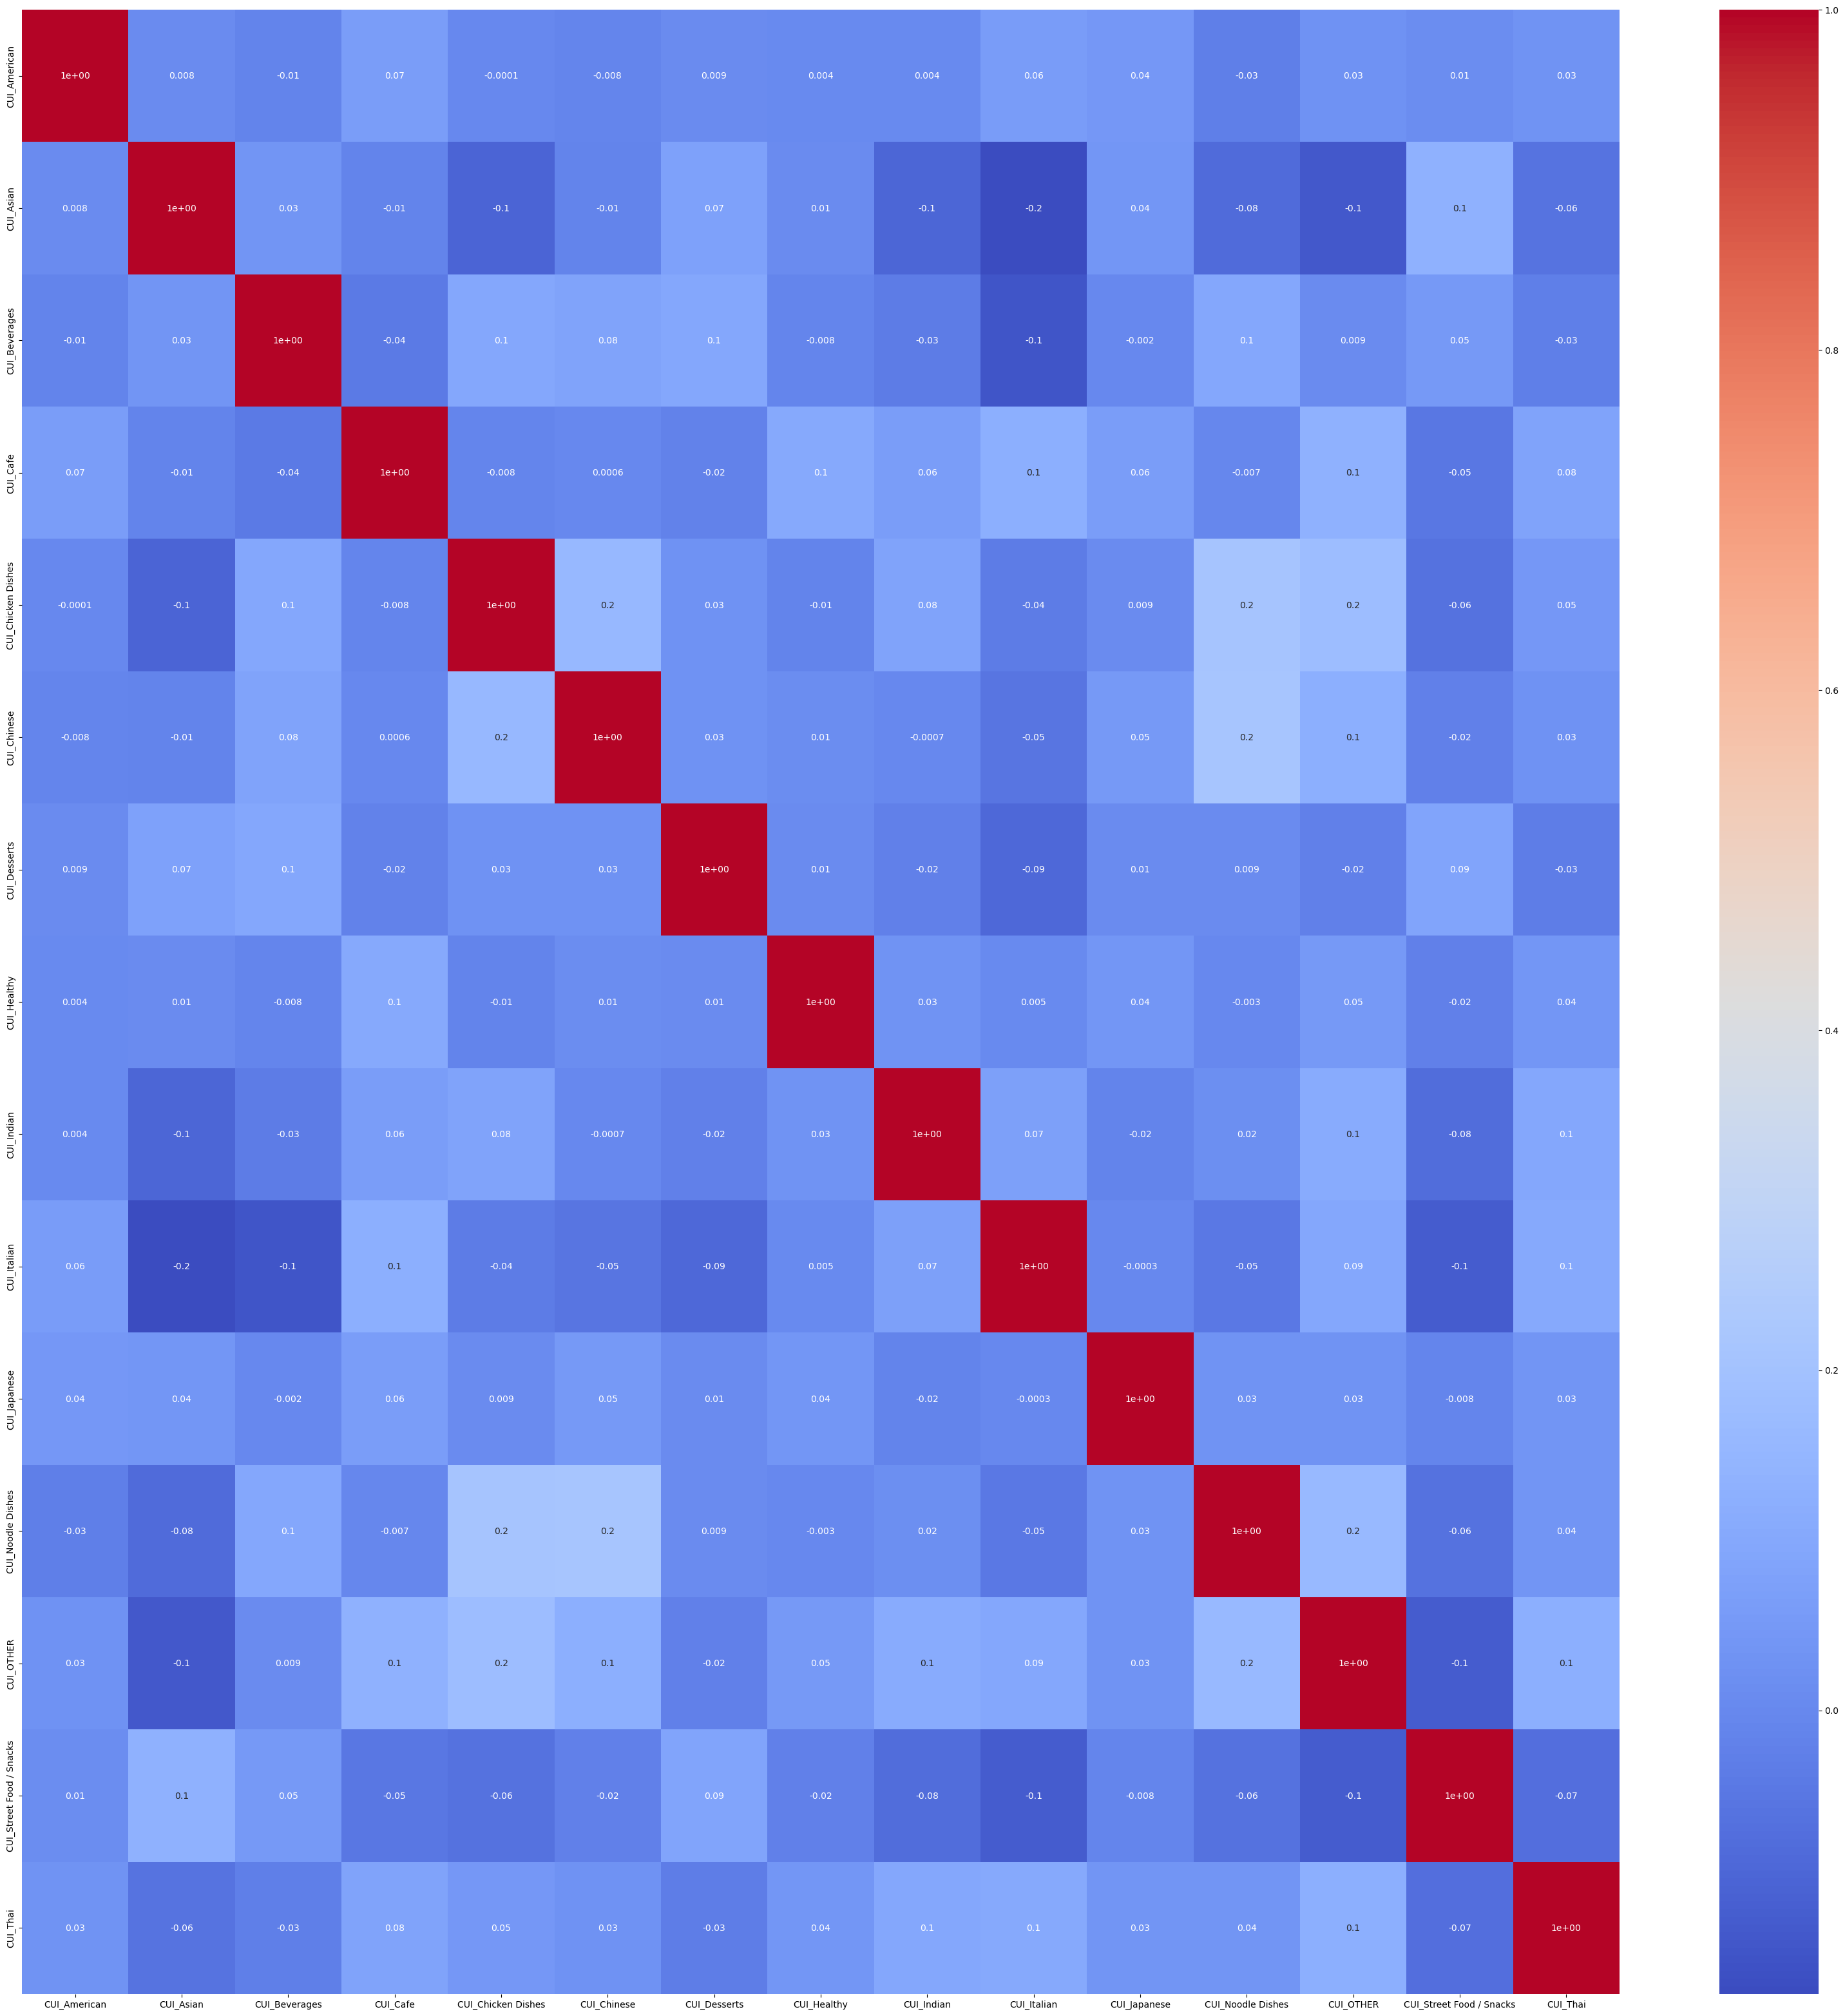

In [15]:
CUI_cor_spearman = df[cuisine_columns].corr(method = 'spearman')
cor_heatmap(CUI_cor_spearman)

__`Step 13`__ Updating new feature `CUI_Chinese` to also accomodate `CUI_Chicken Dishes`.

In [16]:
df['CUI_Chinese'] = df[['CUI_Chinese', 'CUI_Chicken Dishes']].sum(axis=1)

__`Step 13.1`__ Creating a new feature `CUI_IndianOceanic` that aggregates `CUI_India` and `CUI_Thai`.

In [17]:
df['CUI_IndianOceanic'] = df[['CUI_Indian', 'CUI_Thai']].sum(axis=1)

__`Step 13.2`__ Create feature `CUI_Western` that aggregates `CUI_American` and `CUI_Italian`.

In [18]:
df['CUI_Western'] = df[['CUI_American', 'CUI_Italian']].sum(axis=1)

__`Step 13.3`__ Create feature `CUI_Street_Food_Beverages` that aggregates the values in `CUI_Street Food / Snacks` and `CUI_Beverages`.

In [19]:
df['CUI_Street_Food_Beverages'] = df[['CUI_Street Food / Snacks', 'CUI_Beverages']].sum(axis=1)

**Aggregation of Cuisine Features**

The aggregation of features related to cuisine was performed not only based on logical grouping but also with careful consideration of the relationships among the features being aggregated. Specifically, aggregated features do not include individual features that have different types of relationships with each other. 

For example, in **`CUI_ShouteastAsia`**, all the individual features combined to create this aggregated feature exhibit positive relationships with each other, ensuring consistency within the aggregation.

---

**Why Is This Approach Valid?**

This method ensures that:
1. **Logical Consistency**: Aggregated features represent coherent groups where the relationships among components reinforce the overall meaning of the feature.
2. **Avoidance of Misleading Results**: Mixing features with conflicting relationships (e.g., one feature positively correlated while another is negatively correlated) could lead to misleading or non-intuitive results during analysis.
3. **Enhanced Interpretability**: By ensuring that features aggregated into a single group behave similarly, the resulting feature is more interpretable and meaningful for clustering.


__`Step 14`__ Create a list named `var_freq_enc` that stores the features that will encoded through frequency encoding.

In [20]:
var_freq_enc = ['last_promo', 'payment_method', 'customer_region']

__`Step 15`__ Define a function to perform frequency encoding and 2 others to revert the transformation.

In [21]:
# Define a function to perform frequency encoding
def frequency_encoding(df, columns):
    for column in columns:
        # Calculate the frequency of each category in the column
        freq_encoding = df[column].value_counts()
        # Replace categories with their corresponding frequencies
        df[column] = df[column].map(freq_encoding)
    
    return df

In [22]:
# Define function to store the original values
def store_original_values(df, column_names):
    """
    This function stores the original values in multiple columns along with their indices.
    
    Args:
    df: pandas DataFrame containing the data.
    column_names: List of column names to track original values and their indices.
    
    Returns:
    A dictionary where keys are column names, and values are dictionaries 
    of original values with their corresponding indices.
    """
    original_dict = {}

    # Iterate over each column
    for column_name in column_names:
        column_dict = {}
        for idx, value in enumerate(df[column_name]):
            if value not in column_dict:
                column_dict[value] = []
            column_dict[value].append(idx)
        original_dict[column_name] = column_dict
    
    return original_dict

# Store the original values in each row to reverse the transformation afterwards
original_values = store_original_values(df, var_freq_enc)

# Define function to restore the original values 
def restore_original_values(df, original_dict):
    """
    This function restores the original values in multiple columns using the original dictionary.
    
    Args:
    df: pandas DataFrame containing the data.
    original_dict: Dictionary with column names as keys and the original value dictionaries as values.
    
    Returns:
    A DataFrame with the columns restored to their original values.
    """
    # Create a copy of the DataFrame to avoid modifying the original one
    df_copy = df.copy()

    # Iterate over the dictionary and restore original values for each column
    for column_name, column_dict in original_dict.items():
        for value, indices in column_dict.items():
            for idx in indices:
                df_copy.at[idx, column_name] = value
    
    return df_copy

__`Step 15.1`__ Perform frequency encoding in the categorical features except `is_chain`.

In [23]:
df = frequency_encoding(df, var_freq_enc)

**Reasoning for frequency encoding**

- During the Exploratory Data Analysis (EDA), we observed that there are missing values in the dataset that need to be addressed. Most imputation techniques require categorical variables to be encoded as numerical features.

**Why Frequency Encoding?**

- Unlike methods such as OneHotEncoding, frequency encoding does not create additional features.
- It simplifies reconversion to the original categories, as each category is represented by its frequency value. This ensures the encoded features remain interpretable.
- Since we won’t directly use categorical features in clustering algorithms for the two perspectives we will analyze later, frequency encoding provides a compact and efficient encoding approach.

__`Step 16`__ Dropping variable `is_chain`.

In [24]:
df.drop('is_chain', axis=1, inplace=True)

**Reasons to Drop the `is_chain` Variable**

- Due to an inconsistency observed between the metadata and the values in the `is_chain` column, we have decided to remove this variable from the analysis. Furthermore, analysis shows that **71%** of the customers have a value in the `is_chain` column between 0 and 3, indicating a high level of redundancy in the data.
- Even if we were to treat this feature as binary (with 0 for `is_chain` values of 0 and 1 for all other values), it would likely dominate the importance in any clustering algorithm. This is because such a binary transformation would result in the feature either having the minimum or maximum distance, creating an artificial distinction that would skew the clustering process.
- Given that we already have a sufficient set of features that enable us to effectively segment customers, dropping the `is_chain` variable will not significantly impact the model's performance. This decision helps streamline the dataset and avoids introducing potential bias in the clustering algorithms.

## 4.3. Handling Missing Values

__`Step 17`__ Imputing missing values in column `HR_0` as the difference between the values in columns `D_orders` and `H_orders`.

In [25]:
# Calculating the difference where HR_0 is missing
df.loc[df['HR_0'].isnull(), 'HR_0'] = df['D_orders'] - df['H_orders']

# Verifying the changes
missing_hr0_after = df['HR_0'].isnull().sum()
print(f"Number of missing values in 'HR_0' after substitution: {missing_hr0_after}")

Number of missing values in 'HR_0' after substitution: 0


__`Step 17.1`__ Recalculating `H_orders` and `Nights` and checking if the values in `D_orders` and `H_orders` match as they should.

In [26]:
# Recalculating 'H_orders' after updating 'HR_0'
df['H_orders'] = df[['HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 
                         'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 
                         'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 
                         'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']].sum(axis=1)

# Recalculating 'Night' after updating 'HR_0'
df['Night'] = df[['HR_21', 'HR_22', 'HR_23', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4']].sum(axis=1) 

# Comparing 'T_orders' and 'H_orders' to see if they are equal
are_equal_after_recalculation = (df['D_orders'] == df['H_orders']).all()

if are_equal_after_recalculation:
    print("All values in 'D_orders' and 'H_orders' are equal after recalculation.")
else:
    print("There are still differences between 'T_orders' and 'H_orders' after recalculation.")

All values in 'D_orders' and 'H_orders' are equal after recalculation.


__`Step 18`__ Remove all unecessary features from the dataset.

In [27]:
columns_to_drop = ['CUI_Beverages', 'CUI_Chicken Dishes', 'CUI_Indian', 'CUI_Thai', 'CUI_American', 'CUI_Italian', 'CUI_Street Food / Snacks', 
                   'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_0', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 
                   'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 
                   'HR_22', 'HR_23', 'D_orders', 'H_orders']

df.drop(columns_to_drop, axis=1, inplace=True)

**Feature Removal Rationale**

1. **`HR_` and `DOW_` Features**  
   The `HR_` and `DOW_` features were removed because we created aggregated features that effectively capture the same information while reducing dimensionality. This approach simplifies the dataset and improves computational efficiency.

2. **Cuisine Features (`CUI_Beverages`, `CUI_Chicken Dishes`, `CUI_Indian`, `CUI_Thai`, `CUI_American`, `CUI_Italian`, `CUI_Street Food / Snacks`)**  
   These features were removed as they were aggregated into higher-level features. This aggregation not only reduces redundancy but also creates more robust variables that encapsulate broader trends.

3. **`D_Orders` and `H_Orders` Features**  
   The `D_Orders` and `H_Orders` features were dropped because they represent a high level of aggregation. Instead, we retained features with lower levels of aggregation, which provide more granular and useful information for analysis. However, `D_Orders` and `H_Orders` served their purpose by helping to resolve missing values in the `HR_0` feature before being removed.


__`Step 19`__ Imputing values in `first_order` as 0 if the value in the `last_order` equals 0.

In [28]:
df.loc[(df['last_order'] == 0) & (df['first_order'].isna()), 'first_order'] = 0

__`Step 20`__ Scaling the data to be able to make imputation through K-Nearest Neighbours.

In [29]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_df = scaler.fit_transform(df)

# Convert the result back to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

__`Step 20.1`__ Performing imputation of the remaining missing values through KNN with 5 clusters.

In [30]:
# Define the columns you want to impute
columns_to_imput = ['customer_age', 'first_order', 'product_count']

# Initialize the KNN imputer (you can set the number of neighbors, e.g., n_neighbors=5)
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the KNN imputation on the specified columns
scaled_df[columns_to_imput] = knn_imputer.fit_transform(scaled_df[columns_to_imput])

__`Step 20.2`__ Recalculate column `dayswus`.

In [31]:
scaled_df['dayswus'] = scaled_df['last_order'].max() - scaled_df['first_order']

__`Step 20.3`__ Checking if there are remaining missing values that need to be imputted.

In [32]:
scaled_df.isna().sum()

customer_region              0
customer_age                 0
vendor_count                 0
product_count                0
first_order                  0
last_order                   0
last_promo                   0
payment_method               0
CUI_Asian                    0
CUI_Cafe                     0
CUI_Chinese                  0
CUI_Desserts                 0
CUI_Healthy                  0
CUI_Japanese                 0
CUI_Noodle Dishes            0
CUI_OTHER                    0
Orders_Weekday               0
Orders_Weekend               0
Early_Morning                0
Morning                      0
Afternoon                    0
Evening                      0
Night                        0
dayswus                      0
recency                      0
CUI_IndianOceanic            0
CUI_Western                  0
CUI_Street_Food_Beverages    0
dtype: int64

__`Step 20.4`__ Check the percentage of the original dataset that already was removed.

In [33]:
print(f'{round((1 - (scaled_df.shape[0] / data.shape[0])) * 100, 2)}% of the original dataset has been removed so far.')

2.96% of the original dataset has been removed so far.


__`Step 20.5`__ Reversing  the frequency encoding previously done.

In [34]:
scaled_df = restore_original_values(scaled_df, original_values)

C:\Users\danie\AppData\Local\Temp\ipykernel_10500\2387521456.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DELIVERY' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.at[idx, column_name] = value
C:\Users\danie\AppData\Local\Temp\ipykernel_10500\2387521456.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DIGI' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.at[idx, column_name] = value
C:\Users\danie\AppData\Local\Temp\ipykernel_10500\2387521456.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2360' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.at[idx, column_name] = value


__`Step 20.6`__ Checking if the columns were corretly reconverted.

In [35]:
print(f"{scaled_df['payment_method'].value_counts()}\n")
print(f"{scaled_df['last_promo'].value_counts()}\n")
print(f"{scaled_df['customer_region'].value_counts()}")

payment_method
CARD    19591
DIGI     5902
CASH     5450
Name: count, dtype: int64

last_promo
NONE        16251
DELIVERY     6091
DISCOUNT     4354
FREEBIE      4247
Name: count, dtype: int64

customer_region
8670       9386
4660       9313
2360       8589
2440       1448
4140        834
8370        483
UNKNOWN     440
2490        437
8550         13
Name: count, dtype: int64


## 4.4. Outliers

__`Step 21`__ Recreating the list `cuisines_columns` so that it incompasses all the columns with information about cuisines that were kept.

In [36]:
cuisine_columns = ['CUI_Asian', 'CUI_Cafe', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER',
                  'CUI_IndianOceanic', 'CUI_Western', 'CUI_Street_Food_Beverages']

__`Step 21.1`__ Check the outliers in the columns regarding cuisine.

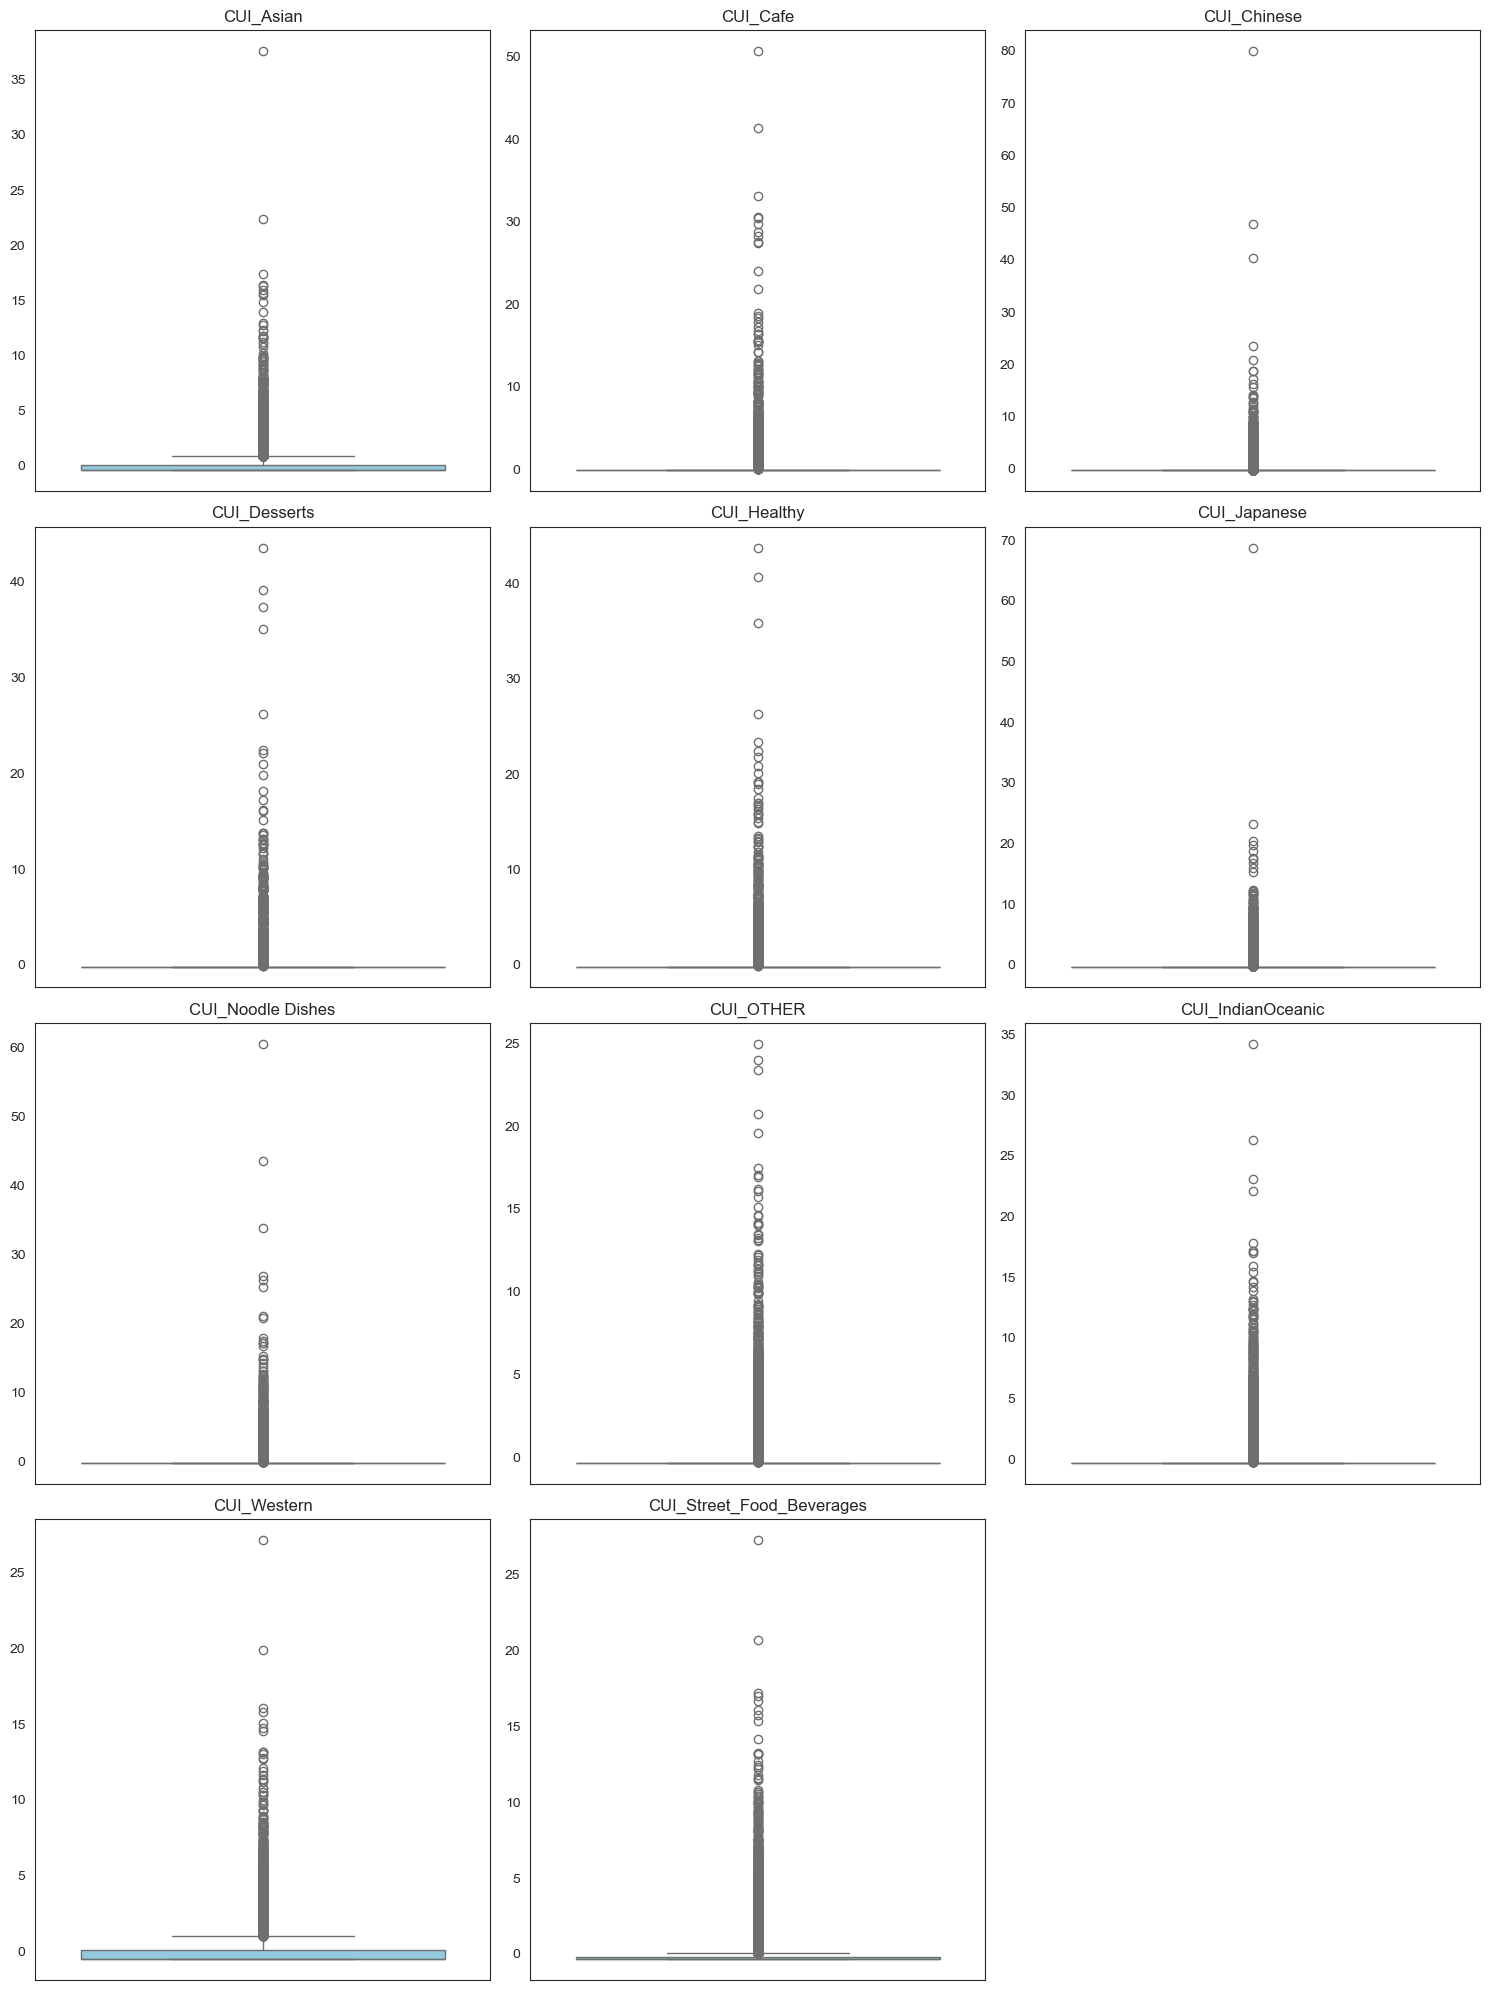

In [37]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Set Seaborn style to white
sns.set_style('white')

# Define the grid size
num_cols = 3  # Number of columns in the grid
num_rows = -(-len(cuisine_columns) // num_cols)  # Calculate rows needed (ceil division)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten axes for easy iteration

# Create boxplots
for i, column in enumerate(cuisine_columns):
    sns.boxplot(data=scaled_df, y=column, ax=axes[i], color="skyblue")
    axes[i].set_title(column, fontsize=12)
    axes[i].set_ylabel('')  # Remove ylabel for a cleaner look

# Remove empty subplots
for j in range(len(cuisine_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()

__`Step 21.2`__ Removing the most extreme outliers from the dataset.

In [38]:
scaled_df = scaled_df[scaled_df['CUI_Asian'] < 35]
scaled_df = scaled_df[scaled_df['CUI_Cafe'] < 50]
scaled_df = scaled_df[scaled_df['CUI_Chinese'] < 80]
scaled_df = scaled_df[scaled_df['CUI_Desserts'] < 40]
scaled_df = scaled_df[scaled_df['CUI_Healthy'] < 40]
scaled_df = scaled_df[scaled_df['CUI_Japanese'] < 70]
scaled_df = scaled_df[scaled_df['CUI_Noodle Dishes'] < 60]
scaled_df = scaled_df[scaled_df['CUI_IndianOceanic'] < 35]
scaled_df = scaled_df[scaled_df['CUI_Western'] < 25]
scaled_df = scaled_df[scaled_df['CUI_Street_Food_Beverages'] < 25]

__`Step 21.3`__ Check the percentage of the original dataset that already was removed.

In [39]:
print(f'{round((1 - (scaled_df.shape[0] / data.shape[0])) * 100, 2)}% of the original dataset has been removed so far.')

2.99% of the original dataset has been removed so far.


__`Step 22`__ Recreating lists `dow_columns` and `hr_columns` to accomodate the columns that remained in the dataset.` 

In [40]:
dow_columns = ['Orders_Weekday', 'Orders_Weekend']

hr_columns = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

__`Step 22.1`__ Plot the boxplot of the `dow_columns`.

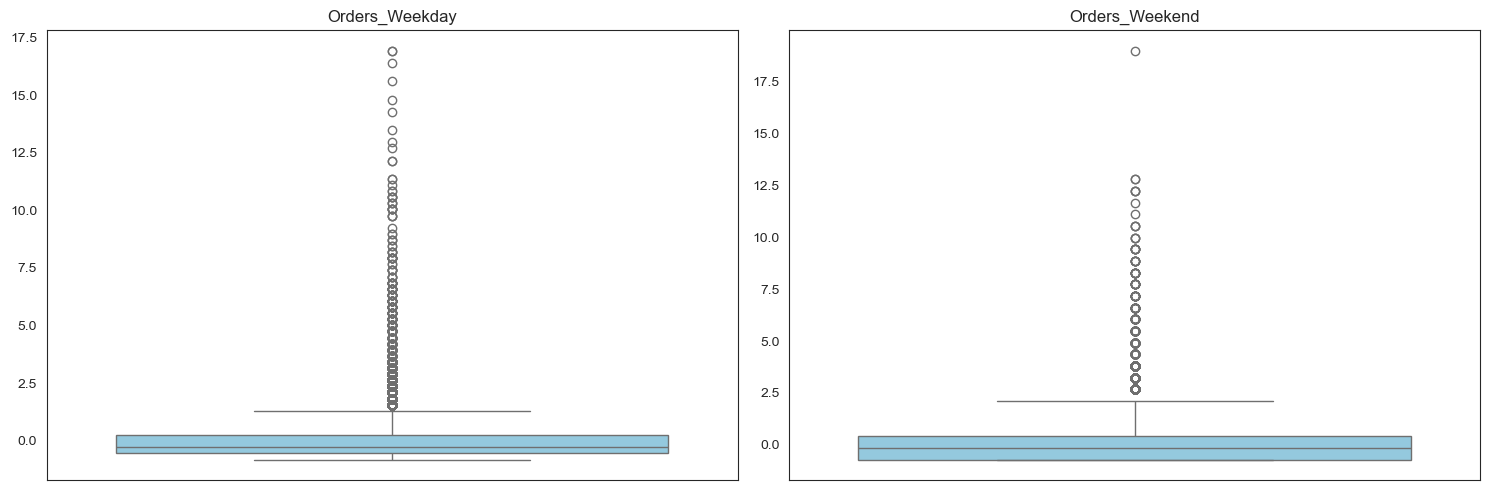

In [41]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Set Seaborn style to white
sns.set_style('white')

# Define the grid size
num_cols = 2
num_rows = 1  

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
axes = axes.flatten()  # Flatten axes for easy iteration

# Create boxplots
for i, column in enumerate(dow_columns):
    sns.boxplot(data=scaled_df, y=column, ax=axes[i], color="skyblue")
    axes[i].set_title(column, fontsize=12)
    axes[i].set_ylabel('')

# Adjust layout
fig.tight_layout()
plt.show()

__`Step 22.2`__ Plot the boxplot of the `hr_columns`.

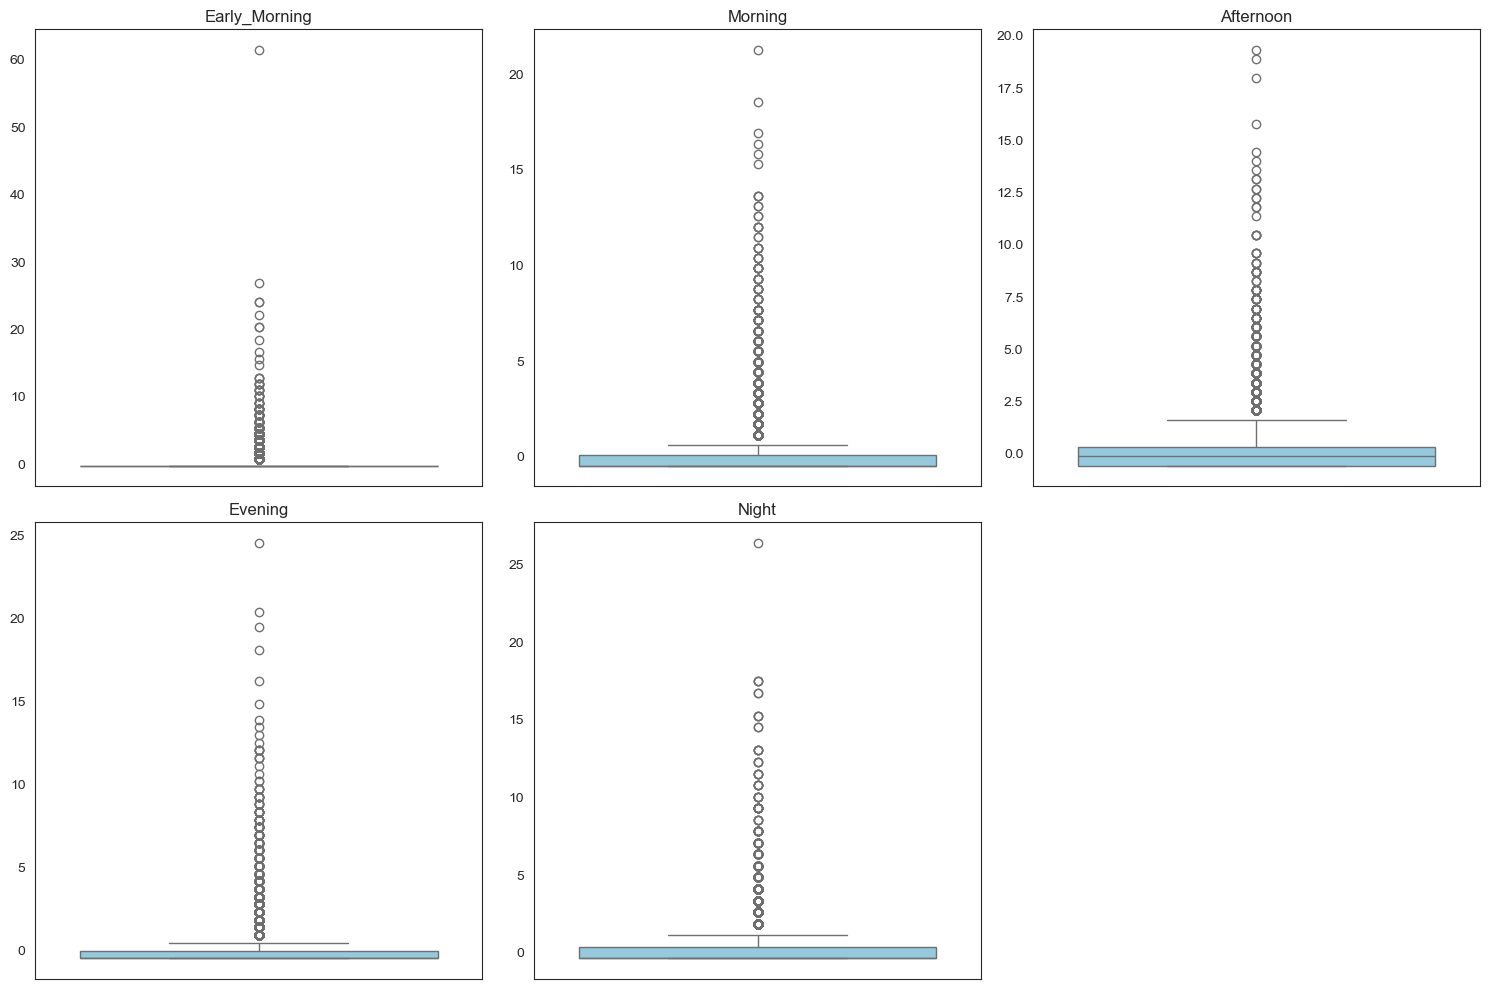

In [42]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Set Seaborn style to white
sns.set_style('white')

# Define the grid size
num_cols = 3
num_rows = -(-len(hr_columns) // num_cols)  # Calculate rows needed (ceil division)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5)) 
axes = axes.flatten()  # Flatten axes for easy iteration

# Create boxplots
for i, column in enumerate(hr_columns):
    sns.boxplot(data=scaled_df, y=column, ax=axes[i], color="skyblue")
    axes[i].set_title(column, fontsize=12)
    axes[i].set_ylabel('')  # Remove ylabel for a cleaner look

# Remove empty subplots (if any)
for j in range(len(hr_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()

__`Step 22.3`__ Removing the most extreme outliers.

In [43]:
scaled_df = scaled_df[scaled_df['Early_Morning'] < 60]
scaled_df = scaled_df[scaled_df['Morning'] < 20]
scaled_df = scaled_df[scaled_df['Evening'] < 22]
scaled_df = scaled_df[scaled_df['Night'] < 20]

__`Step 22.4`__ Check the percentage of rows that were removed.

In [44]:
print(f'{round((1 - (scaled_df.shape[0] / data.shape[0])) * 100, 2)}% of the original dataset has been removed so far.')

3.0% of the original dataset has been removed so far.


**Decisions regarding outlier removal**

- The majority of our features contain numerous outliers. Removing all of them would significantly alter the data distribution, effectively changing the underlying reality it represents. Therefore, we have chosen to remove only the most extreme outliers to maintain the integrity of the data.
- We decided to remove outliers from the `cuisines_columns` and `hr_columns` as these will be used in the two perspectives discussed in Section 6. Since the clustering algorithms will operate on these columns and are sensitive to outliers, addressing them is essential.
- In the end of outlier removal we concluded that only **3%** of the dataset was removed which is below the **5%** threshold previously mentioned.

# 5. Feature Selection

__`Step 23`__ Creating a list with the numerical and the categorical features.

In [45]:
# List of numerical features
numerical_features = ['customer_age', 'vendor_count', 'product_count', 'first_order', 'last_order', 'CUI_Asian', 'CUI_Cafe', 'CUI_Chinese', 
                      'CUI_Noodle Dishes', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Japanese', 'CUI_OTHER', 'CUI_IndianOceanic', 'CUI_Western', 
                      'CUI_Street_Food_Beverages', 'Orders_Weekday', 'Orders_Weekend', 'Early_Morning', 'Morning', 'Afternoon', 'Evening', 
                      'Night', 'dayswus', 'recency']

# List of categorical features
categorical_features = ['last_promo', 'payment_method', 'customer_region']


__`Step 24`__ Checking the variance of the variables.

In [46]:
scaled_df[numerical_features].var()

customer_age                 1.000234
vendor_count                 0.995759
product_count                0.969973
first_order                  1.000009
last_order                   1.000067
CUI_Asian                    0.945342
CUI_Cafe                     0.917073
CUI_Chinese                  0.999685
CUI_Noodle Dishes            0.881617
CUI_Desserts                 0.938123
CUI_Healthy                  0.883870
CUI_Japanese                 0.996414
CUI_OTHER                    0.996845
CUI_IndianOceanic            0.999266
CUI_Western                  0.976483
CUI_Street_Food_Beverages    0.972360
Orders_Weekday               0.975132
Orders_Weekend               0.978861
Early_Morning                0.874733
Morning                      0.972554
Afternoon                    0.982766
Evening                      0.978388
Night                        0.975692
dayswus                      1.000009
recency                      1.000067
dtype: float64

__`Step 25`__ Checking the correlation between numerical features.

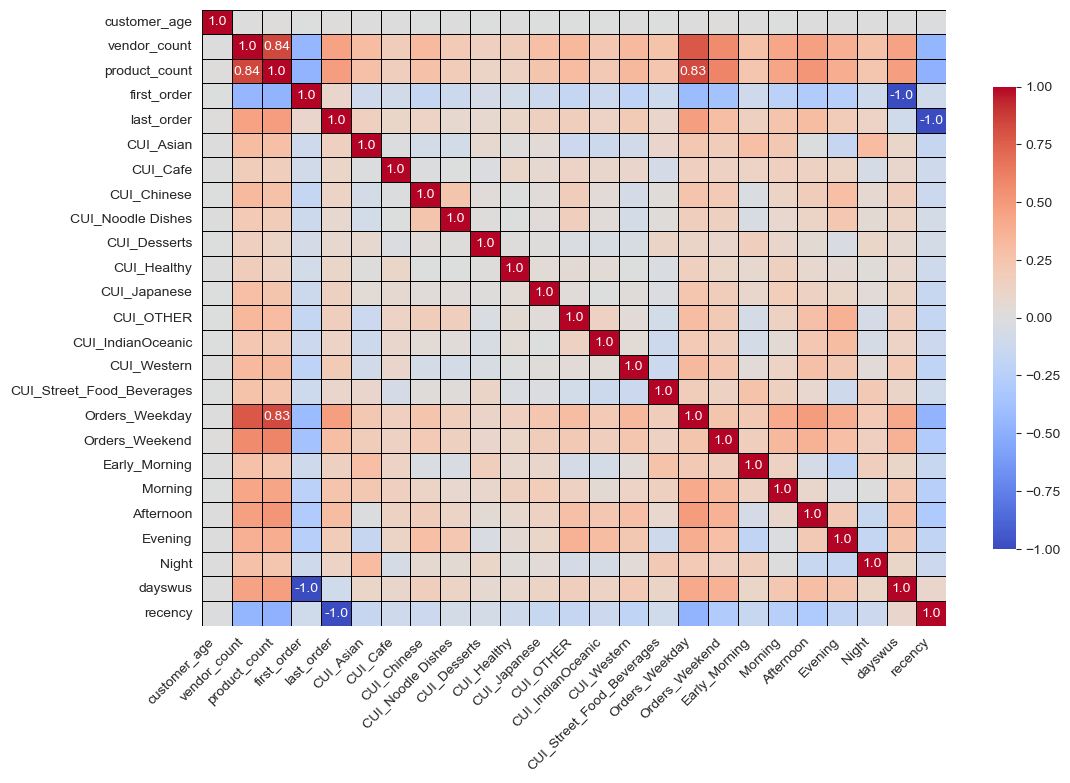

In [47]:
cor_spearman = scaled_df[numerical_features].corr(method='spearman')
cor_heatmap1(cor_spearman)

**Redundant and Relevant features**

**Predictor**              | **Variance** | **Spearman** | **Conclusion**
---------------------------|--------------|--------------|------------------------
customer_age               | Keep         | Keep         | Relevant feature
vendor_count               | Keep         | Keep         | Relevant feature
product_count              | Keep         | Discard      | Redundant feature (Drop)
first_order                | Keep         | Discard      | Redundant feature (Drop)
last_order                 | Keep         | Discard      | Redundant feature (Drop)
CUI_Asian                  | Keep         | Keep         | Relevant feature
CUI_Cafe                   | Keep         | Keep         | Relevant feature
CUI_Chinese                | Keep         | Keep         | Relevant feature
CUI_Desserts               | Keep         | Keep         | Relevant feature
CUI_Healthy                | Keep         | Keep         | Relevant feature
CUI_Japanese               | Keep         | Keep         | Relevant feature
CUI_Noodle Dishes          | Keep         | Keep         | Relevant feature
CUI_Other                  | Keep         | Keep         | Relevant feature
CUI_IndianOceanic          | Keep         | Keep         | Relevant feature
CUI_Western                | Keep         | Keep         | Relevant feature
CUI_Street_Food_Beverages  | Keep         | Keep         | Relevant feature
Orders_Weekday             | Keep         | Keep         | Relevant feature
Orders_Weekend             | Keep         | Keep         | Relevant feature
Early_Morning              | Keep         | Keep         | Relevant feature
Morning                    | Keep         | Keep         | Relevant feature
Afternoon                  | Keep         | Keep         | Relevant feature
Evening                    | Keep         | Keep         | Relevant feature
Night                      | Keep         | Keep         | Relevant feature
dayswus                    | Keep         | Keep         | Relevant feature
recency                    | Keep         | Keep         | Relevant feature

__`Step 26`__ Drop the redundant features from the dataset.

In [48]:
scaled_df.drop(['product_count', 'first_order', 'last_order'], axis=1, inplace=True)

# Updating list numeric features to remove those three columns 
numerical_features = [col for col in numerical_features if col not in ['product_count', 'first_order', 'last_order']]

# 6. Clustering

__`Step 27`__ Divide the columns of the dataset into 2 different perspectives: `cuisine_preferences` and `customer_activity`.

In [49]:
customer_activity = ['Orders_Weekday', 'Orders_Weekend', 'Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'dayswus', 'recency']

cuisine_preferences = ['CUI_Asian', 'CUI_Cafe', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 
                       'CUI_IndianOceanic', 'CUI_Western', 'CUI_Street_Food_Beverages']

## 6.1. Cuisine_activity perspective

__`Step 28`__ Creating perspective1 to apply the best clustering solution.

In [50]:
perspective1 = scaled_df[customer_activity]

# Checking the number of rows and columns from the new created dataframe
perspective1.shape

(30931, 9)

__`Step 28.1`__ Create a copy of the first perspective.

In [51]:
perspective1_normalized = perspective1.copy()

__`Step 29`__ Perform the Johnson SU transformation on the data.

In [52]:
# Function to apply the Johnson transformation to a single column
def johnson_transform(x):
    param_estimates = johnsonsu.fit(x)  # Fit the distribution to the data (excluding NaN values)
    transformed_data = johnsonsu(*param_estimates).cdf(x)  # Apply the transformation (cumulative distribution function)
    return transformed_data

# Apply the Johnson transformation to all numeric columns
for column in perspective1_normalized.select_dtypes(include=[np.number]).columns:
    perspective1_normalized[column] = johnson_transform(perspective1_normalized[column])

__`Step 30`__ Perform kmeans clustering with the optimum number of clusters (k = 4).

In [53]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=90)
labels2 = kmeans.fit_predict(perspective1_normalized)

## 6.2. Cuisine Preferences perspective

__`Step 31`__ Create `perspective2` with the columns for the cuisine_preferences perspective.

In [54]:
perspective2 = scaled_df[cuisine_preferences]

# Checking the number of rows and columns from the new created dataframe 
perspective2.shape

(30931, 11)

__`Step 31.1`__ Create a copy of the second perspective.

In [55]:
perspective2_normalized = perspective2.copy()

__`Step 32`__ Perform the Johnson SU transformation on the data.

In [56]:
# Apply the Johnson transformation to all numeric columns
for column in perspective2_normalized.select_dtypes(include=[np.number]).columns:
    perspective2_normalized[column] = johnson_transform(perspective2_normalized[column])

__`Step 33`__ Perform Hierarchical Clustering with the optimal number of clusters.

In [57]:
# 5 cluster solution
n_clusters = 5
linkage = 'ward'
distance = 'euclidean'

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels4 = hc4_clust.fit_predict(perspective2_normalized)

# 7. Profiling

## 7.1. Joining both perspectives

__`Step 34`__ Creating the labels of the 2 perspectives in the `scaled_df` dataset.

In [58]:
scaled_df['customer_activity_labels'] = labels2
scaled_df['cuisine_preferences_labels'] = hc4_labels4

__`Step 35`__ Apply the Johnson SU transformation to the original scaled dataset.

In [59]:
# Apply the Johnson transformation to specific columns within lists
columns_to_transform = customer_activity + cuisine_preferences + ['customer_age', 'vendor_count'] # Combine the lists of columns

for column in columns_to_transform:
    if column in scaled_df.columns:  # Ensure the column exists
        scaled_df[column] = johnson_transform(scaled_df[column])

__`Step 36`__ Create a contigency table to see the size of the several clusters we have.

In [60]:
# Count label frequencies (contigency table)

pd.crosstab(scaled_df['customer_activity_labels'],
            scaled_df['cuisine_preferences_labels'])

cuisine_preferences_labels     0     1     2     3    4
customer_activity_labels                               
0                           4308  3144   812  1007  950
1                           1820  2426   443   387  756
2                           3380  1318  1584   558  770
3                           2275  3500   206   663  624

- We can see that we have some clusters with low frequencies like (1, 3), (1, 2) and (3,2).

__`Step 37`__ Check the centroids of the clusters.

In [61]:
# Get centroids of clusters
df_centroids = scaled_df.groupby(['customer_activity_labels', 'cuisine_preferences_labels'])\
    [numerical_features].mean()


df_centroids

customer_age  \
customer_activity_labels cuisine_preferences_labels                 
0                        0                               0.499417   
                         1                               0.500355   
                         2                               0.513325   
                         3                               0.497459   
                         4                               0.493742   
1                        0                               0.497031   
                         1                               0.496115   
                         2                               0.510954   
                         3                               0.490487   
                         4                               0.475396   
2                        0                               0.501308   
                         1                               0.505580   
                         2                               0.488772   
                         3                               0.485354   
                         4                               0.488077   
3                        0                               0.506906   
                         1                               0.505917   
                         2                               0.513425   
                         3                               0.495939   
                         4                               0.505696   

                                                     vendor_count  CUI_Asian  \
customer_activity_labels cuisine_preferences_labels                            
0                        0                               0.799896   0.572552   
                         1                               0.589947   0.673053   
                         2                               0.997749   0.617513   
                         3                               0.758756   0.555512   
                         4                               0.791332   0.620472   
1                        0                               0.825918   0.661952   
                         1                               0.633946   0.795786   
                         2                               0.997780   0.705255   
                         3                               0.778532   0.566800   
                         4                               0.816441   0.724225   
2                        0                               0.966502   0.686025   
                         1                               0.898866   0.788002   
                         2                               0.998306   0.739813   
                         3                               0.970140   0.639851   
                         4                               0.973396   0.741103   
3                        0                               0.638395   0.558795   
                         1                               0.443583   0.720433   
                         2                               0.997381   0.621779   
                         3                               0.545963   0.512104   
                         4                               0.590400   0.593555   

                                                     CUI_Cafe  CUI_Chinese  \
customer_activity_labels cuisine_preferences_labels                          
0                        0                           0.315779     0.521636   
                         1                           0.283688     0.566570   
                         2                           0.341028     0.563383   
                         3                           0.283688     0.592886   
                         4                           0.283688     0.557483   
1                        0                           0.341150     0.508782   
                         1                           0.283688     0.529686   
                         2                           0.335431     0.525

__`Step 38`__ Perform hierarchical clustering in the centroids of the clusters to make the join of the clusters.

In [62]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

__`Step 39`__ Check the dendrogram of the hierarchical clustering previously done.

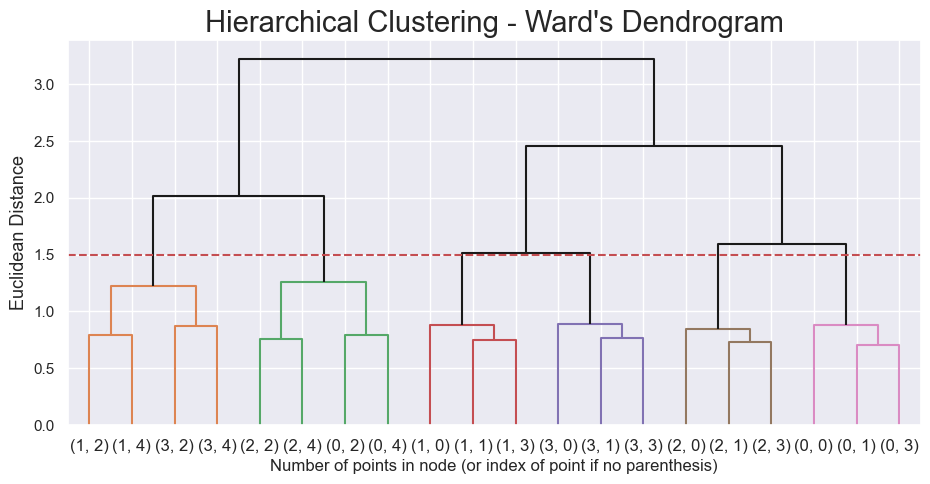

In [63]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 1.5

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)

# Save the dendrogram as an image
plt.savefig("dendrogram.png", dpi=300, bbox_inches='tight')

plt.show()

- We consider that using 6 clusters as the best number of clusters to keep.

__`Step 40`__ Merge the centroids into 6 clusters with hierarchical clustering.

In [64]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

customer_age  \
customer_activity_labels cuisine_preferences_labels                 
0                        0                               0.499417   
                         1                               0.500355   
                         2                               0.513325   
                         3                               0.497459   
                         4                               0.493742   
1                        0                               0.497031   
                         1                               0.496115   
                         2                               0.510954   
                         3                               0.490487   
                         4                               0.475396   
2                        0                               0.501308   
                         1                               0.505580   
                         2                               0.488772   
                         3                               0.485354   
                         4                               0.488077   
3                        0                               0.506906   
                         1                               0.505917   
                         2                               0.513425   
                         3                               0.495939   
                         4                               0.505696   

                                                     vendor_count  CUI_Asian  \
customer_activity_labels cuisine_preferences_labels                            
0                        0                               0.799896   0.572552   
                         1                               0.589947   0.673053   
                         2                               0.997749   0.617513   
                         3                               0.758756   0.555512   
                         4                               0.791332   0.620472   
1                        0                               0.825918   0.661952   
                         1                               0.633946   0.795786   
                         2                               0.997780   0.705255   
                         3                               0.778532   0.566800   
                         4                               0.816441   0.724225   
2                        0                               0.966502   0.686025   
                         1                               0.898866   0.788002   
                         2                               0.998306   0.739813   
                         3                               0.970140   0.639851   
                         4                               0.973396   0.741103   
3                        0                               0.638395   0.558795   
                         1                               0.443583   0.720433   
                         2                               0.997381   0.621779   
                         3                               0.545963   0.512104   
                         4                               0.590400   0.593555   

                                                     CUI_Cafe  CUI_Chinese  \
customer_activity_labels cuisine_preferences_labels                          
0                        0                           0.315779     0.521636   
                         1                           0.283688     0.566570   
                         2                           0.341028     0.563383   
                         3                           0.283688     0.592886   
                         4                           0.283688     0.557483   
1                        0                           0.341150     0.508782   
                         1                           0.283688     0.529686   
                         2                           0.335431     0.525

__`Step 41`__ Create a mapper to check the changes from the original cluster profiling and the new one with the merge already done.

In [65]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 2,
 (0, 1): 2,
 (0, 2): 0,
 (0, 3): 2,
 (0, 4): 0,
 (1, 0): 5,
 (1, 1): 5,
 (1, 2): 1,
 (1, 3): 5,
 (1, 4): 1,
 (2, 0): 4,
 (2, 1): 4,
 (2, 2): 0,
 (2, 3): 4,
 (2, 4): 0,
 (3, 0): 3,
 (3, 1): 3,
 (3, 2): 1,
 (3, 3): 3,
 (3, 4): 1}

__`Step 42`__ Create a dataframe that stores the clusters for both perspectives and the merged labels.

In [66]:
df_ = scaled_df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['customer_activity_labels'], row['cuisine_preferences_labels'])
    ], axis=1
)

df_ 

customer_region  customer_age  vendor_count last_promo payment_method  \
0                2360      0.018580      0.996572   DELIVERY           DIGI   
1                8670      0.005300      0.996572   DISCOUNT           DIGI   
2                4660      0.919048      0.142646   DISCOUNT           CASH   
3                4660      0.088462      0.996572       NONE           DIGI   
4                8670      0.940714      0.996572    FREEBIE           DIGI   
...               ...           ...           ...        ...            ...   
30938            8670      0.145265      0.142646   DELIVERY           DIGI   
30939            8670      0.718932      0.142646    FREEBIE           DIGI   
30940            8670      0.359401      0.142646       NONE           DIGI   
30941            8670      0.848467      0.142646   DISCOUNT           DIGI   
30942            4660      0.718932      0.142646       NONE           CASH   

       CUI_Asian  CUI_Cafe  CUI_Chinese  CUI_Desserts  CUI_Healthy  ...  \
0       0.462666  0.283688     0.451187      0.544392     0.487304  ...   
1       1.000000  0.283688     0.451187      0.544392     0.487304  ...   
2       0.462666  0.283688     0.451187      0.544392     0.487304  ...   
3       1.000000  0.283688     0.451187      0.544392     0.487304  ...   
4       1.000000  0.283688     0.451187      0.544392     0.487304  ...   
...          ...       ...          ...           ...          ...  ...   
30938   0.462666  0.283688     0.451187      0.544392     0.487304  ...   
30939   0.462666  0.283688     0.451187      0.544392     0.487304  ...   
30940   0.462666  0.283688     0.451187      1.000000     0.487304  ...   
30941   1.000000  0.283688     0.451187      0.544392     0.487304  ...   
30942   0.462666  0.283688     0.451187      0.544392     0.487304  ...   

        Evening     Night   dayswus   recency  CUI_IndianOceanic  CUI_Western  \
0      0.999969  0.372101  0.977415  0.943582           1.000000     0.236190   
1      0.427977  0.372101  0.977415  0.943582           0.490812     0.960011   
2      0.427977  0.372101  0.977415  0.943582           0.490812     0.956255   
3      0.427977  0.372101  0.977415  0.942337           0.490812     0.961387   
4      0.427977  1.000000  0.977415  0.942337           0.490812     0.236190   
...         ...       ...       ...       ...                ...          ...   
30938  0.427977  0.372101  0.977415  0.944793           0.490812     0.236190   
30939  0.427977  0.372101  0.977415  0.944793           0.490812     0.236190   
30940  0.427977  0.372101  0.977415  0.944793           0.490812     0.236190   
30941  0.427977  0.372101  0.977415  0.944793           0.490812     0.236190   
30942  0.427977  0.372101  0.977415  0.944793           0.490812     0.954453   

       CUI_Street_Food_Beverages  customer_activity_labels  \
0                       0.659614                         3   
1                       0.659614                         1   
2                       0.659614                         1   
3                       0.659614                         1   
4                       0.659614                         3   
...                          ...                       ...   
30938                   1.000000                         1   
30939                   1.000000                         0   
30940                   0.659614                         3   
30941                   0.659614                         1   
30942                   0.659614                         0   

       cuisine_preferences_labels  merged_labels  
0                               1              3  
1                               0              5  
2                               0              5  
3                               0              5  
4                               1              3  
...                           ...            ...  
30938                           1              5  
30939                         

__`Step 43`__ Check the centorids of merged clusters solution.

In [67]:
# Merged cluster centroids
df_.groupby('merged_labels').mean(numeric_only=True)[numerical_features]

customer_age  vendor_count  CUI_Asian  CUI_Cafe  CUI_Chinese  \
merged_labels                                                                 
0                  0.494633      0.945765   0.688383  0.347557     0.598390   
1                  0.496339      0.804887   0.669496  0.298162     0.512317   
2                  0.499532      0.716966   0.607877  0.300031     0.546819   
3                  0.505239      0.522967   0.641861  0.292366     0.520748   
4                  0.500685      0.949928   0.706695  0.351013     0.610318   
5                  0.496005      0.721437   0.724084  0.306261     0.526408   

               CUI_Noodle Dishes  CUI_Desserts  CUI_Healthy  CUI_Japanese  \
merged_labels                                                               
0                       0.374116      0.579924     0.539620      1.000000   
1                       0.321996      0.565724     0.517879      1.000000   
2                       0.338210      0.567229     0.509669      0.005582   
3                       0.330737      0.564561     0.506416      0.005582   
4                       0.369584      0.589121     0.543880      0.005582   
5                       0.328924      0.574779     0.529577      0.005582   

               CUI_OTHER  ...  CUI_Street_Food_Beverages  Orders_Weekday  \
merged_labels             ...                                              
0               0.576406  ...                   0.760588        0.702153   
1               0.424539  ...                   0.727053        0.487205   
2               0.510424  ...                   0.747859        0.450924   
3               0.454735  ...                   0.728347        0.338165   
4               0.597439  ...                   0.790820        0.695518   
5               0.453251  ...                   0.763280        0.425676   

               Orders_Weekend  Early_Morning   Morning  Afternoon   Evening  \
merged_labels                                                                 
0                    0.863681       0.528358  0.653086   0.999995  0.774286   
1                    0.750108       0.587182  0.668871   0.058528  0.639125   
2                    0.732243       0.446072  0.190551   0.999993  0.676882   
3                    0.638988       0.534879  0.190551   0.058528  0.722321   
4                    0.874342       0.527538  0.999677   0.999994  0.714626   
5                    0.723265       0.533664  0.999984   0.058528  0.552918   

                  Night   dayswus   recency  
merged_labels                                
0              0.528008  0.607035  0.374638  
1              0.614719  0.464024  0.521127  
2              0.475947  0.460970  0.541280  
3              0.643527  0.382051  0.628199  
4              0.518802  0.615450  0.393550  
5              0.543137  0.440016  0.555830  

[6 rows x 22 columns]

__`Step 44`__ Check the size of each cluster looking for imbalance in the clusters.

In [68]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

0
merged_labels      
0              4116
1              2029
2              8459
3              6438
4              5256
5              4633

- We can see that there is not a huge class imbalance in the clustering solution.

__`Step 44.1`__ Check the frequency of each cluster with the number of the clusters perspectives.

In [69]:
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts

merged_labels     0
0        (2, 4)  4116
1        (3, 4)  2029
2        (0, 3)  8459
3        (3, 3)  6438
4        (2, 3)  5256
5        (1, 3)  4633

__`Step 44.2`__ Extracting Customer Activity and Cuisine Preference Labels from Merged Labels.

In [70]:
df_counts['customer_activity_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['cuisine_preference_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts

merged_labels     0  customer_activity_labels  cuisine_preference_labels
0        (2, 4)  4116                         2                          4
1        (3, 4)  2029                         3                          4
2        (0, 3)  8459                         0                          3
3        (3, 3)  6438                         3                          3
4        (2, 3)  5256                         2                          3
5        (1, 3)  4633                         1                          3

__`Step 44.3`__ Creating a Pivot Table for Customer Activity and Cuisine Preference Labels.

In [71]:
df_counts.pivot(values=0, index='customer_activity_labels', columns='cuisine_preference_labels')

cuisine_preference_labels       3       4
customer_activity_labels                 
0                          8459.0     NaN
1                          4633.0     NaN
2                          5256.0  4116.0
3                          6438.0  2029.0

__`Step 45`__ Create a copy of the `df_` dataset naming it `df` to be used in the next steps.

In [83]:
df = df_.copy()

## 7.2. Cluster Analysis

__`Step 46`__ Create a function to perform the graph that will be used for profiling the clusters.

In [73]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(y=0.5, color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)

    # Save the figure if a path is provided
    plt.savefig('cluster_analysis.png', dpi=300, bbox_inches='tight')

    # Show the figure
    plt.show()

__`Step 46.1`__ Apply the function to make the analysis of the clusters.

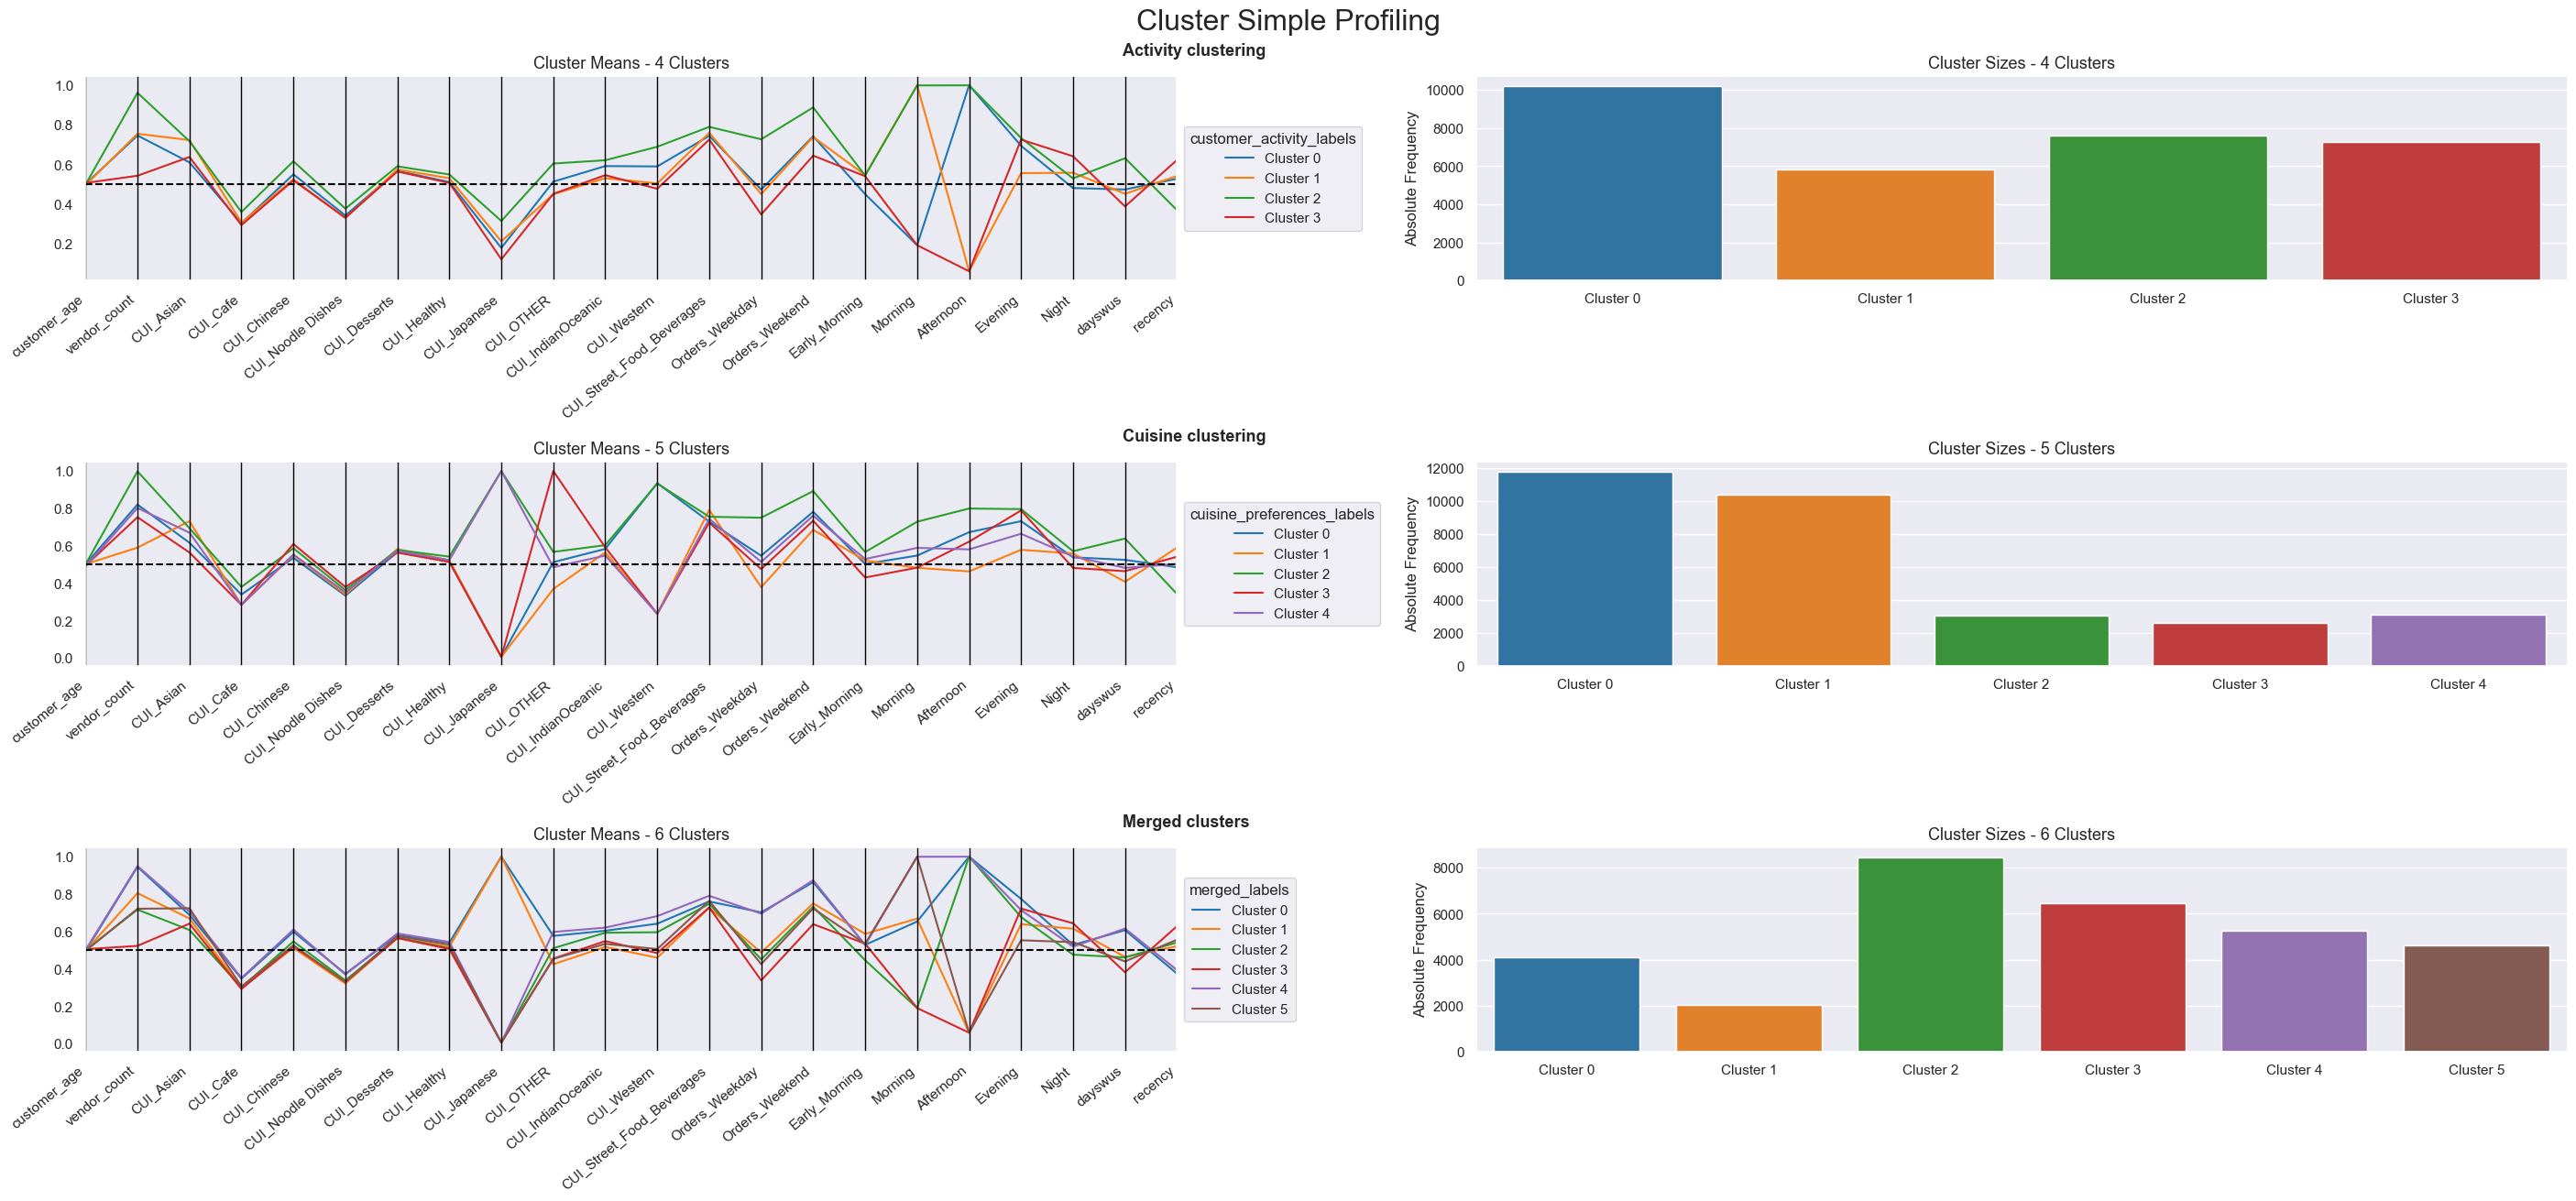

In [74]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[numerical_features + ['customer_activity_labels', 'cuisine_preferences_labels', 'merged_labels']], 
    label_columns = ['customer_activity_labels', 'cuisine_preferences_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Activity clustering", "Cuisine clustering", "Merged clusters"]
)

## 7.3. Profilling using categorical features

__`Step 47`__ Make the profiling of the clusters based on the feature `customer_region`.

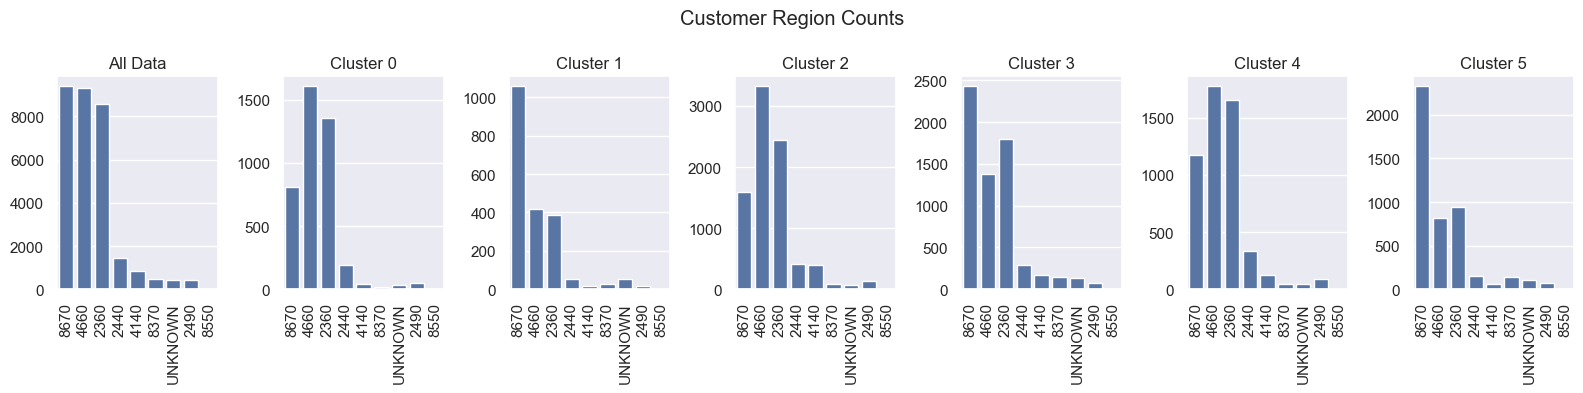

In [75]:
fig, axes = plt.subplots(1, 
                         df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=df, 
                      x='customer_region', 
                      order=df['customer_region'].value_counts().index,
                      ax=ax)
        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=df[df['merged_labels'] == i-1], 
                      x='customer_region', 
                      order=df['customer_region'].value_counts().index,
                      ax=ax)
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Customer Region Counts")
plt.show()


__`Step 47.1`__ Make the profiling of the clusters based on the feature `payment_method`.

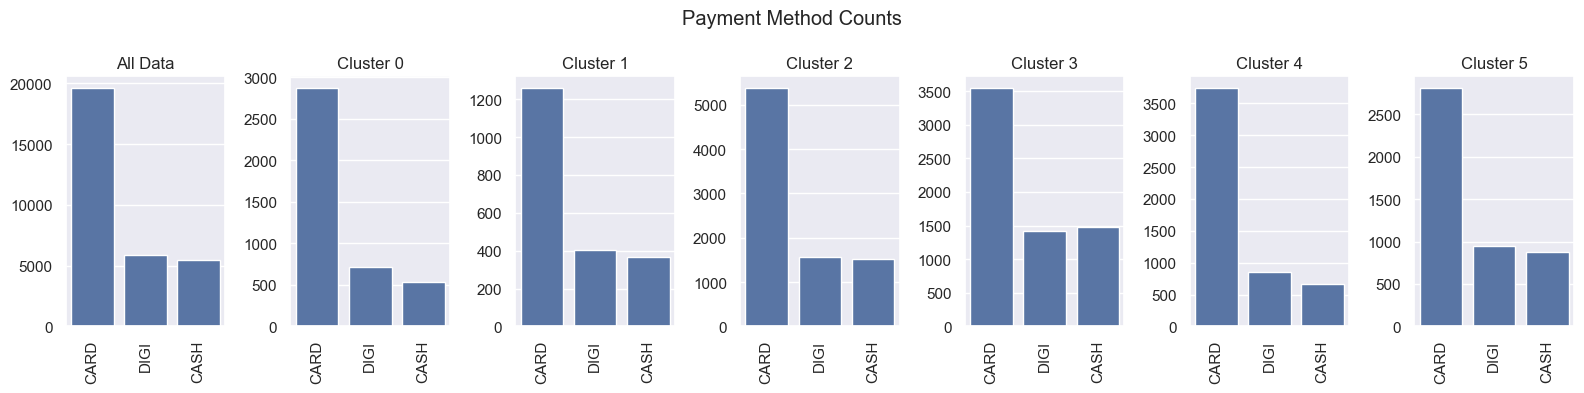

In [76]:
fig, axes = plt.subplots(1, 
                         df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=df, 
                      x='payment_method', 
                      order=df['payment_method'].value_counts().index,
                      ax=ax)
        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=df[df['merged_labels'] == i-1], 
                      x='payment_method', 
                      order=df['payment_method'].value_counts().index,
                      ax=ax)
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Payment Method Counts")
plt.show()


__`Step 47.2`__ Make the profiling of the clusters based on the feature `last_promo`.

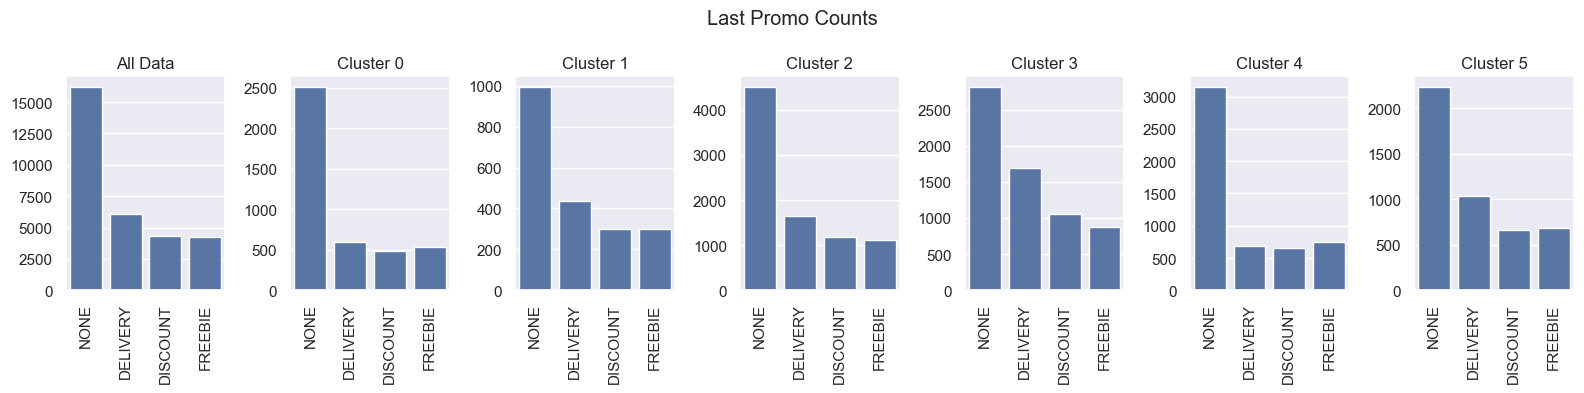

In [77]:
fig, axes = plt.subplots(1, 
                         df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=df, 
                      x='last_promo', 
                      order=df['last_promo'].value_counts().index,
                      ax=ax)
        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=df[df['merged_labels'] == i-1], 
                      x='last_promo', 
                      order=df['last_promo'].value_counts().index,
                      ax=ax)
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Last Promo Counts")
plt.show()


- We can see from the 3 previous graphs that `customer_region` is the only categorical feature that exhibits significant differences between the clusters.

__`Step 47.3`__ Make stacked bar plots of the categorical features based on the cluster labels to check if there are significant differences between the clusters.

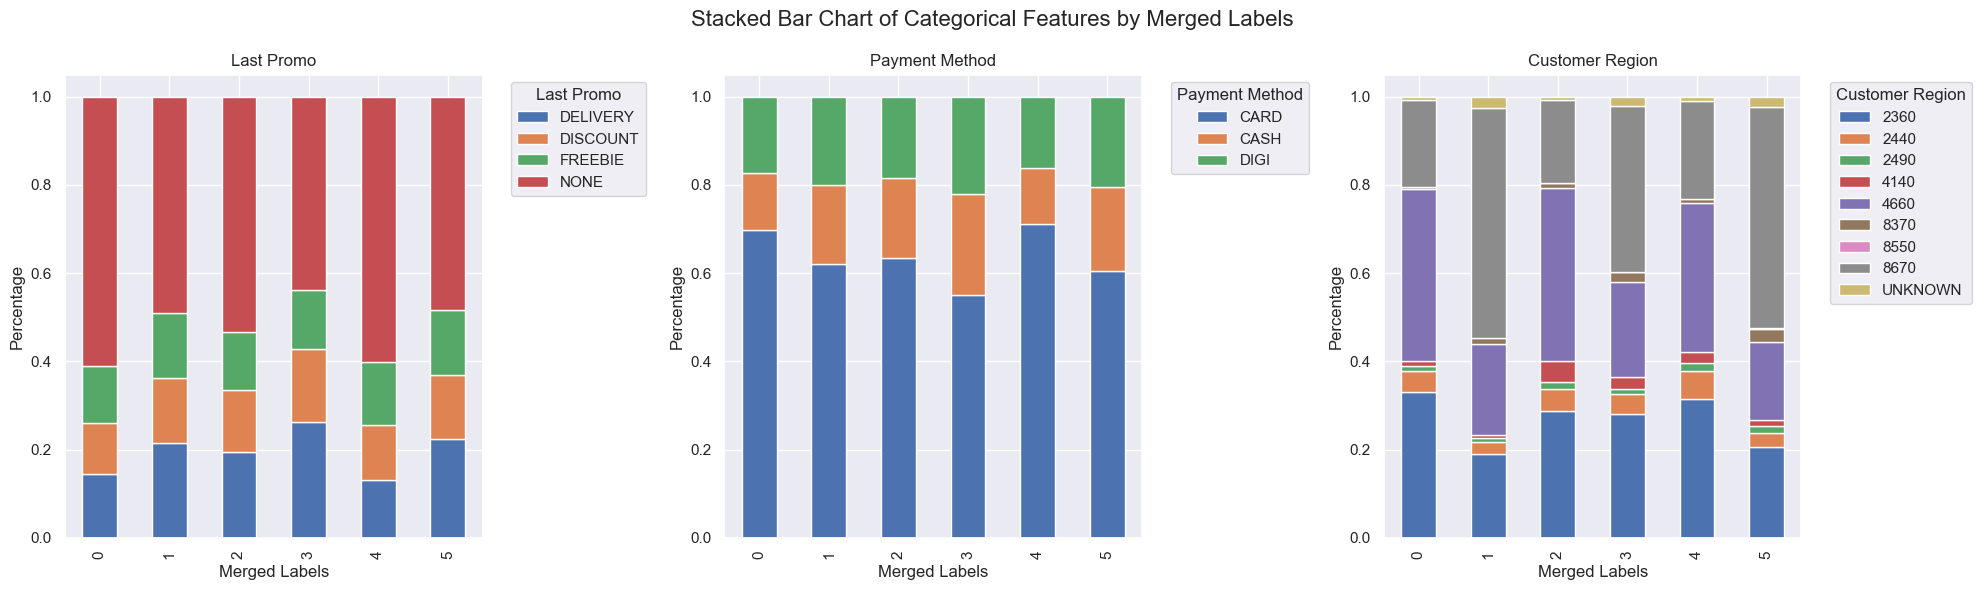

In [78]:
# Set up the figure and axes
fig, axes = plt.subplots(1, len(categorical_features), figsize=(20, 6), tight_layout=True)

# Loop through each categorical feature
for i, feature in enumerate(categorical_features):
    ax = axes[i]

    # Compute percentages for each category within each merged_label
    percentage_data = (
        df.groupby('merged_labels')[feature]
          .value_counts(normalize=True)
          .rename('percentage')
          .reset_index()
    )

    # Pivot the data for stacked bar plotting
    pivot_data = percentage_data.pivot(index='merged_labels', columns=feature, values='percentage')

    # Create a stacked bar chart using default colors
    pivot_data.plot(kind='bar', stacked=True, ax=ax)

    # Customize the plot
    ax.set_title(feature.replace('_', ' ').title())
    ax.set_xlabel("Merged Labels")
    ax.set_ylabel("Percentage")
    ax.legend(title=feature.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Overall title
plt.suptitle("Stacked Bar Chart of Categorical Features by Merged Labels", fontsize=16)
plt.show()

# 8. Cluster Visualization

__`Step 48`__ Creating a mapping to change the number of the customers to the labels that we gave them.

In [84]:
merged_labels_mapping = {
    0: "Japanese Food Lovers",
    1: "Japanese Breakfast Lovers",
    2: "Lunch Enthusiasts",
    3: "Worst Customers",
    4: "Best Customers",
    5: "Breakfast Enthusiasts"
}

df['merged_labels'] = df['merged_labels'].map(merged_labels_mapping)


__`Step 48.1`__ Create a 2D visualization of the final clusters using UMAP.

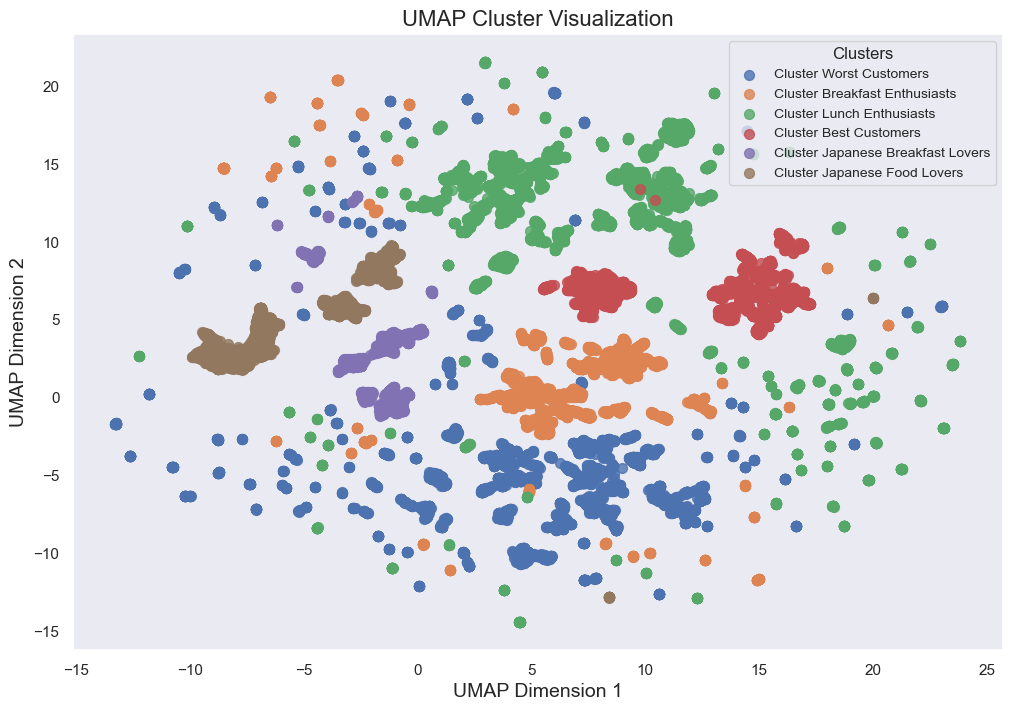

In [85]:
# Perform UMAP dimensionality reduction
umap_model = umap.UMAP(random_state=42)
two_dim = umap_model.fit_transform(df[cuisine_preferences + customer_activity])

# Define a colormap and normalize labels
unique_labels = df['merged_labels'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))

# Plot UMAP visualization
plt.figure(figsize=(12, 8))

for label in unique_labels:
    cluster_points = two_dim[df['merged_labels'] == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {label}', 
                alpha=0.8, 
                s=50)  # Alpha for transparency, s for marker size

# Add title and labels
plt.title('UMAP Cluster Visualization', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Clusters', fontsize=10, title_fontsize=12)
plt.grid(False)  # Cleaner background

# Save the visualization as an image
plt.savefig('umap_cluster_visualization.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

__`Step 49`__ Create a copy of the dataframe `df` that will serve as the dataset to use in the Optinal part of the project.

In [81]:
# Drop unwanted columns
cluster_df = df.copy()

# Rename 'merged_labels' column to 'cluster_labels'
cluster_df = cluster_df.rename(columns={'merged_labels': 'cluster_labels'})

__`Step 50`__ Change the labels of the customer activity and cuisine preferences prespectives to the labels given in the Clustering Testing notebook and saving the dataset into a csv file.

In [82]:
# Define dictionaries for mapping cluster numbers to descriptive labels
customer_activity_mapping = {
    0: "Late Birds",
    1: "Early Birds",
    2: "Best Customers",
    3: "Worst Customers"
}

cuisine_preferences_mapping = {
    0: "Western Cuisine Lovers",
    1: "Asian Street Food Enthusiasts",
    2: "Japano-Western Fusion Fans",
    3: "Diverse Food Explorers",
    4: "Sushi & Beyond Lovers"
}

# Map cluster numbers to descriptive labels in the DataFrame
cluster_df['customer_activity_labels'] = cluster_df['customer_activity_labels'].map(customer_activity_mapping)
cluster_df['cuisine_preferences_labels'] = cluster_df['cuisine_preferences_labels'].map(cuisine_preferences_mapping)

# Export the updated DataFrame to a CSV file
cluster_df.to_csv('dataset_with_clusters.csv', index=False)
